# Tricks and problems :
### Border
+ I clear the border, because object in the border  which have their center below the border are not in the catalogue since i only take the TU_cat for object inside the limite of the test image. But then, the galaxies in th border which have their center ubove ther border are erase, but still int the cat. To take care of that, if the matching object is not found in the image, I pass. When I look for the object not found by the Unet, I also need to not put them on the residual catalogue. I use the same trick to take them off.
+ I also clear more than just the border (I take a marge of 10 piexels), because some GT that touch the border, if they are predicted smaller, will not touch it, for 2 or 3 pixels. And I don't want to put them as FP object just because they are 3 pixels smaller

 Not found :
It looks like most of the not found object are when two object where separate in the ground truth, but considered as one (blended or not) in the prediction. Doing so, the detection find one of the two, even if the shape of the mask see both
<!-- 
### `Measure_label`
It looks like when I identify the object with skimage, there is missing object (if my higher label object is 10, I only have like 8 objects). It does not seem that the module miss objects, but more that there is hole (maybe the clear bored). To take care of that, if the k-th bject found return a 0 value in the map, I pass. I need to check if the not found object can come from that too -->

### Detection of blended objects
This part requires a lot of tricks.
+ I do the measure_label on a map without blended regions (they are artificially put o one instead of two), so that the detection galaxy+blend appears as one consistent region (if not, I have problem like if a matching galaxy fall is tottaly inside it companion, i will only detect the blended region and not the global object. It also sometime causes the same kind of problem with the prediction)
+ If there is FN blend, I will detect it twice (one for each galaxy that should be blended but that I predict as separated. To take care of that, if the matching galaxy companion has already be found, I detect the object as a TP obj/FN blend, but I will subtract all this objects when computing the completeness.
+ Maybe I can find a clever way but for now, the detection of the matching objects are always in the same order, so when I see again a FN blend as in the prvious point, I need to artifically invert the index of the main/companion to have the correct values of the mag and radius
+ If the object is a FN or TP blend, I recompute the area of the gt object to be sure not to miss the companion when searching in the tU_cat. It s particualry important when it's a FN.
ad
### Variance 
For now, I take the variance inside the region of a found object. Should I go a bit more ouside the detection area ? Or even take all the pixels until the variance fall to 0 ? (the third option is hard regarding the cleaning of the stamp...)
![Variance problems](img/var.png)

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.activations import relu
from tensorflow.keras.layers import AveragePooling2D, Conv2D, Dropout, Input, concatenate, Reshape
from tensorflow.keras.backend import resize_images
from skimage import measure
import pandas as pd
import numpy as np
import os
from math import floor, ceil
import argparse
from tqdm import tqdm
from multiprocessing import Process, Queue
import logging
import pickle
from astropy.io import fits
import sys
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
sys.path.append("..")
from test_utils import * #measure_obj, plot_maps, pred_from_trained, produce_cat
from punet_utils import training_utils
tfd = tfp.distributions

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`


In [2]:
tf.__version__

'2.1.0'

# Load the test data

In [3]:
data_path = '/data57/hbretonniere/FVAE/FVAE_emulated_data/for_deblender/phymasks/no_structure/'
stamp_size = 128
x_start = 128     # cut the border of the stamp where there is no galaxies
y_start = 128     # cut the border of the stamp where there is no galaxies
nb_batch = 2
n_row = 2 * nb_batch
n_column = 10# 193 max
cb = 10   #clear border

### Images with mag > 25.2


In [4]:
# hdul = fits.open(data_path + 'WithNoise_no_cut_test_TU_FVAE_divided_1_3_re_field_'+str(4)+'.fits')
# img = hdul[0].data[:x_start + n_row * stamp_size, :y_start + n_column * stamp_size]  #import just the part of the image we want to test on

# hdul = fits.open(data_path + 'no_cut_seg_test_TU_FVAE_divided_1_3_re_field_'+str(4)+'.fits')
# img_seg = hdul[0].data[:x_start + n_row * stamp_size, :y_start + n_column * stamp_size]

# hdul = fits.open(data_path + 'good_Catalog_no_cut_TU_FVAE_divided_1_3_re_field_'+str(4)+'.fits')
# tu_cat = hdul[1].data
# tu_cat = np.array(tu_cat.tolist())
# tu_cat = tu_cat[np.where((tu_cat[:, 3] < x_start + n_row * stamp_size -cb)\
#                          & (tu_cat[:, 2] < y_start + n_column * stamp_size-cb))[0]]  #to take into acount the clear border


### Images without mag > 25.2


In [5]:
# Input Image
hdul = fits.open(data_path + 'WithNoise_TU_FVAE_divided_1_3_re_field_4.fits')
# hdul = fits.open(data_path + 'WithNoise_no_cut_test_TU_FVAE_divided_1_3_re_field_'+str(4)+'.fits')
img = hdul[0].data[:x_start + n_row * stamp_size, :y_start + n_column * stamp_size]  #import just the part of the image we want to test on
img_bit_bigger = hdul[0].data[:x_start + n_row * stamp_size+64, :y_start + n_column * stamp_size+64]  #import just the part of the image we want to test on

# Gt seg
hdul = fits.open(data_path + 'seg_TU_FVAE_divided_1_3_re_field_4.fits')
img_seg = hdul[0].data[:x_start + n_row * stamp_size, :y_start + n_column * stamp_size]
img_seg_bit_bigger = hdul[0].data[:x_start + n_row * stamp_size+64, :y_start + n_column * stamp_size+64]

# Catalogue
# hdul = fits.open(data_path + 'good_Catalog_no_cut_TU_FVAE_divided_1_3_re_field_4.fits')
hdul = fits.open(data_path + 'Catalog_TU_FVAE_divided_1_3_re_field_4.fits')

tu_cat_nocut = hdul[1].data
tu_cat_nocut = np.array(tu_cat_nocut.tolist())
# We need to create a catalogue with only the galaxies that are in the testing image
tu_cat_nocut = tu_cat_nocut[np.where((tu_cat_nocut[:, 3] < x_start + n_row * stamp_size -cb)\
                         & (tu_cat_nocut[:, 2] < y_start + n_column * stamp_size-cb))[0]]  #to take into acount the clear border
tu_cat = tu_cat_nocut[np.where(tu_cat_nocut[:,4] < 25.2)]  # Take only the galaxies that are in the image (ie mag < 25.2)

## Cut the big_field into stamps
The Probab Unet best perform with stamps of $(128\times128)$ pixels. For the first rough detection, we just cut the big input image like a grid. It is sufficient to detect all the object. 

In [6]:
img_test = []
segs_test = []
patch_size = [stamp_size, stamp_size]

x_i = x_start                        # pass the first row stamp which is empty
for i in range(n_row):               # go through all the rows
    y_i = y_start                    # pass the first stamp which is empty
    for j in range(n_column):        # go trough all the columns
        img_test.append(np.arcsinh(img[x_i:x_i + stamp_size, y_i:y_i + stamp_size]/img[x_i:x_i + stamp_size, y_i:y_i + stamp_size].max()))    #grid like cut
        segs_test.append(img_seg[x_i:x_i + stamp_size, y_i:y_i + stamp_size])    #grid like cut

        y_i += stamp_size               # got to the first pixel of the next stamp
    x_i += stamp_size                   # got to the first pixel of the next stamp
img_test = np.asarray(img_test)

img_test = np.expand_dims(img_test, axis=-1)   # add the feature channel
segs_test = np.expand_dims(segs_test, axis=-1)   # add the feature channel
img_test = np.ndarray.astype(img_test, dtype='float32')   # convert to the good type to work with the unet
segs_test = np.ndarray.astype(segs_test, dtype='float32')

print(f" Shape of the images :{img_test.shape}, of the segs :{np.shape(segs_test)}")

 Shape of the images :(40, 128, 128, 1), of the segs :(40, 128, 128, 1)


# Proba Unet Initialisation :

### Proba Unet hyper-parameters

In [7]:
checkpoint_path = "/data57/hbretonniere/deblending/tf2/check_blend_first/"

show = True
num_classes = 3  # background/galaxy/intersection
nb_sample = 20
data_format = 'NCHW'
one_hot_labels = False

cuda_visible_devices = '0'
cpu_device = '/cpu:0'
gpu_device = '/gpu:0'

network_input_shape = (None, 1) + tuple(patch_size)
network_output_shape = (None, num_classes) + tuple(patch_size)
label_shape = (None, 1) + tuple(patch_size)
base_channels = 32
list_num_channels = [base_channels, 2*base_channels, 4*base_channels,
                6*base_channels, 6*base_channels, 6*base_channels, 6*base_channels]

num_conv_per_block = 1
latent_dim = 10
num_1x1_convs = 1

with tf.device(cpu_device):
    proba_unet = create_punet(list_num_channels, num_conv_per_block, num_1x1_convs, stamp_size, latent_dim)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Model: "img_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
img_down_block_0_0 (Conv2D)  (None, 128, 128, 32)      320       
_________________________________________________________________
average_pooling2d_6 (Average (None, 64, 64, 32)        0         
_________________________

### First rough Prediction from the Unet

In [8]:
test_samples, ls, tmp = pred_from_trained(checkpoint_path, proba_unet, img_test, nb_batch, 20, segs=None, mode='Test')

Mode = Test
/data57/hbretonniere/deblending/tf2/check_blend_first/checkpoint_330287


### Plot the three classes output (before the argmax)

In [9]:
segs_test.shape

(40, 128, 128, 1)

In [10]:
# n = 500
# fig, ax = plt.subplots(1, 5, figsize=(40,10))
# ax[0].imshow(segs_test[test_samples.shape[0]-n, :, :, 0])
# for i in range(3):
#     ax[i+1].imshow(tmp[0][test_samples.shape[0]-n, :, :, i], vmin= 0 ,vmax = np.max(tmp[0][test_samples.shape[0]-n, :, :, :]))
# ax[4].imshow(test_samples[test_samples.shape[0]-n, 10 ,:, :])

## Reconstruct the big field
This is the inverse operation of the cutting we made juste before
`big_rec_field` is the entire field reconstructed from the predicted samples. It contains 3 images:
-  The thresholded predicted image
- The mean of different realisations, what we call the "probabily segmentation map".
- The pixel wize variance map of the different realisations

In [11]:
''' Make the stamp a bit bigger at the end so we can show galaxies that are in the edge'''
big_rec_field_rough = np.zeros((3, x_start + n_row * stamp_size+10, y_start + n_column * stamp_size+10)) 
index = 0  # index of the stamp
x_i = x_start  # we start the stamps at 100 of the full image because there is a "blanck cadre" around the image
''' Going trough all the big field, we add he stamp to the corresponding location (side by side)'''
for i in range(n_row):
    y_i = y_start
    for j in range(n_column):
        big_rec_field_rough[1, x_i:x_i+stamp_size, y_i:y_i+stamp_size] = np.mean(test_samples[index], axis=0)
        big_rec_field_rough[2, x_i:x_i+stamp_size, y_i:y_i+stamp_size] = np.var(test_samples[index], axis=0)
        index += 1
        y_i += stamp_size
    x_i += stamp_size

big_rec_field_rough[0] = np.where(big_rec_field_rough[1] > 0.95, 1, 0)
big_rec_field_rough[0] = np.where(big_rec_field_rough[1] > 1.2, 2, big_rec_field_rough[0])

### Object detection
To be able to compute a score for each object (and not each stamps which can contains many objects), we need to detect each object separatly. With the segmentation map, it s easy to do thanks to the skimage library. We do it both on the ground truth and the predidction.
`measure_obj`is a custom function which does the identfication of the objects and the clear label, and also take care of the fact that we don t want to separate the blended and the isolated region of a blended object.

In [12]:
gt_obj_map = measure_obj(img_seg, int(cb/2))
pred_obj_map_rough = measure_obj(big_rec_field_rough[0], cb)

In [13]:
# # liste = []
# # for a in range(segs_test.shape[0]):
# #     if np.max(segs_test[a,: ,: ,0])==2 :
# #         liste.append(a)

# plt.figure(figsize=(10,10))
# plt.imshow(img_test[687, :, :, 0], cmap='bone')

# plt.figure(figsize=(10,10))
# plt.imshow(np.mean(test_samples[687], axis=0), cmap='bone')

# fig, ax = plt.subplots(1,9, figsize=(90,10))
# n = 687 #np.random.choice(liste)
# for i in range(7):
#     ax[i].imshow(test_samples[n, i, :, :])
# ax[7].imshow(np.var(test_samples[n], axis = 0))
# ax[8].imshow(segs_test[n, :, : ,0], cmap='bone')
# print(n)

# plt.figure(figsize=(10,10))
# plt.imshow(np.mean(test_samples[n]))

# fig, ax = plt.subplots(1,20, figsize=(200,10))
# # n = np.random.randint(0, test_samples.shape[0])
# for i in range(19):
#     ax[i].imshow(test_samples[n, i, :, :], cmap='bone')
# ax[19].imshow(np.tanh(5* np.var(test_samples[n], axis = 0)), cmap='bone')
# # ax[8].imshow(segs_test[n, :, : ,0])

blends : 791 516, 582, 687

### Plots
We plot the input image, the gt seg, the gt object map, the ped seg, the pred obj map, and the difference between the gt and the pred.

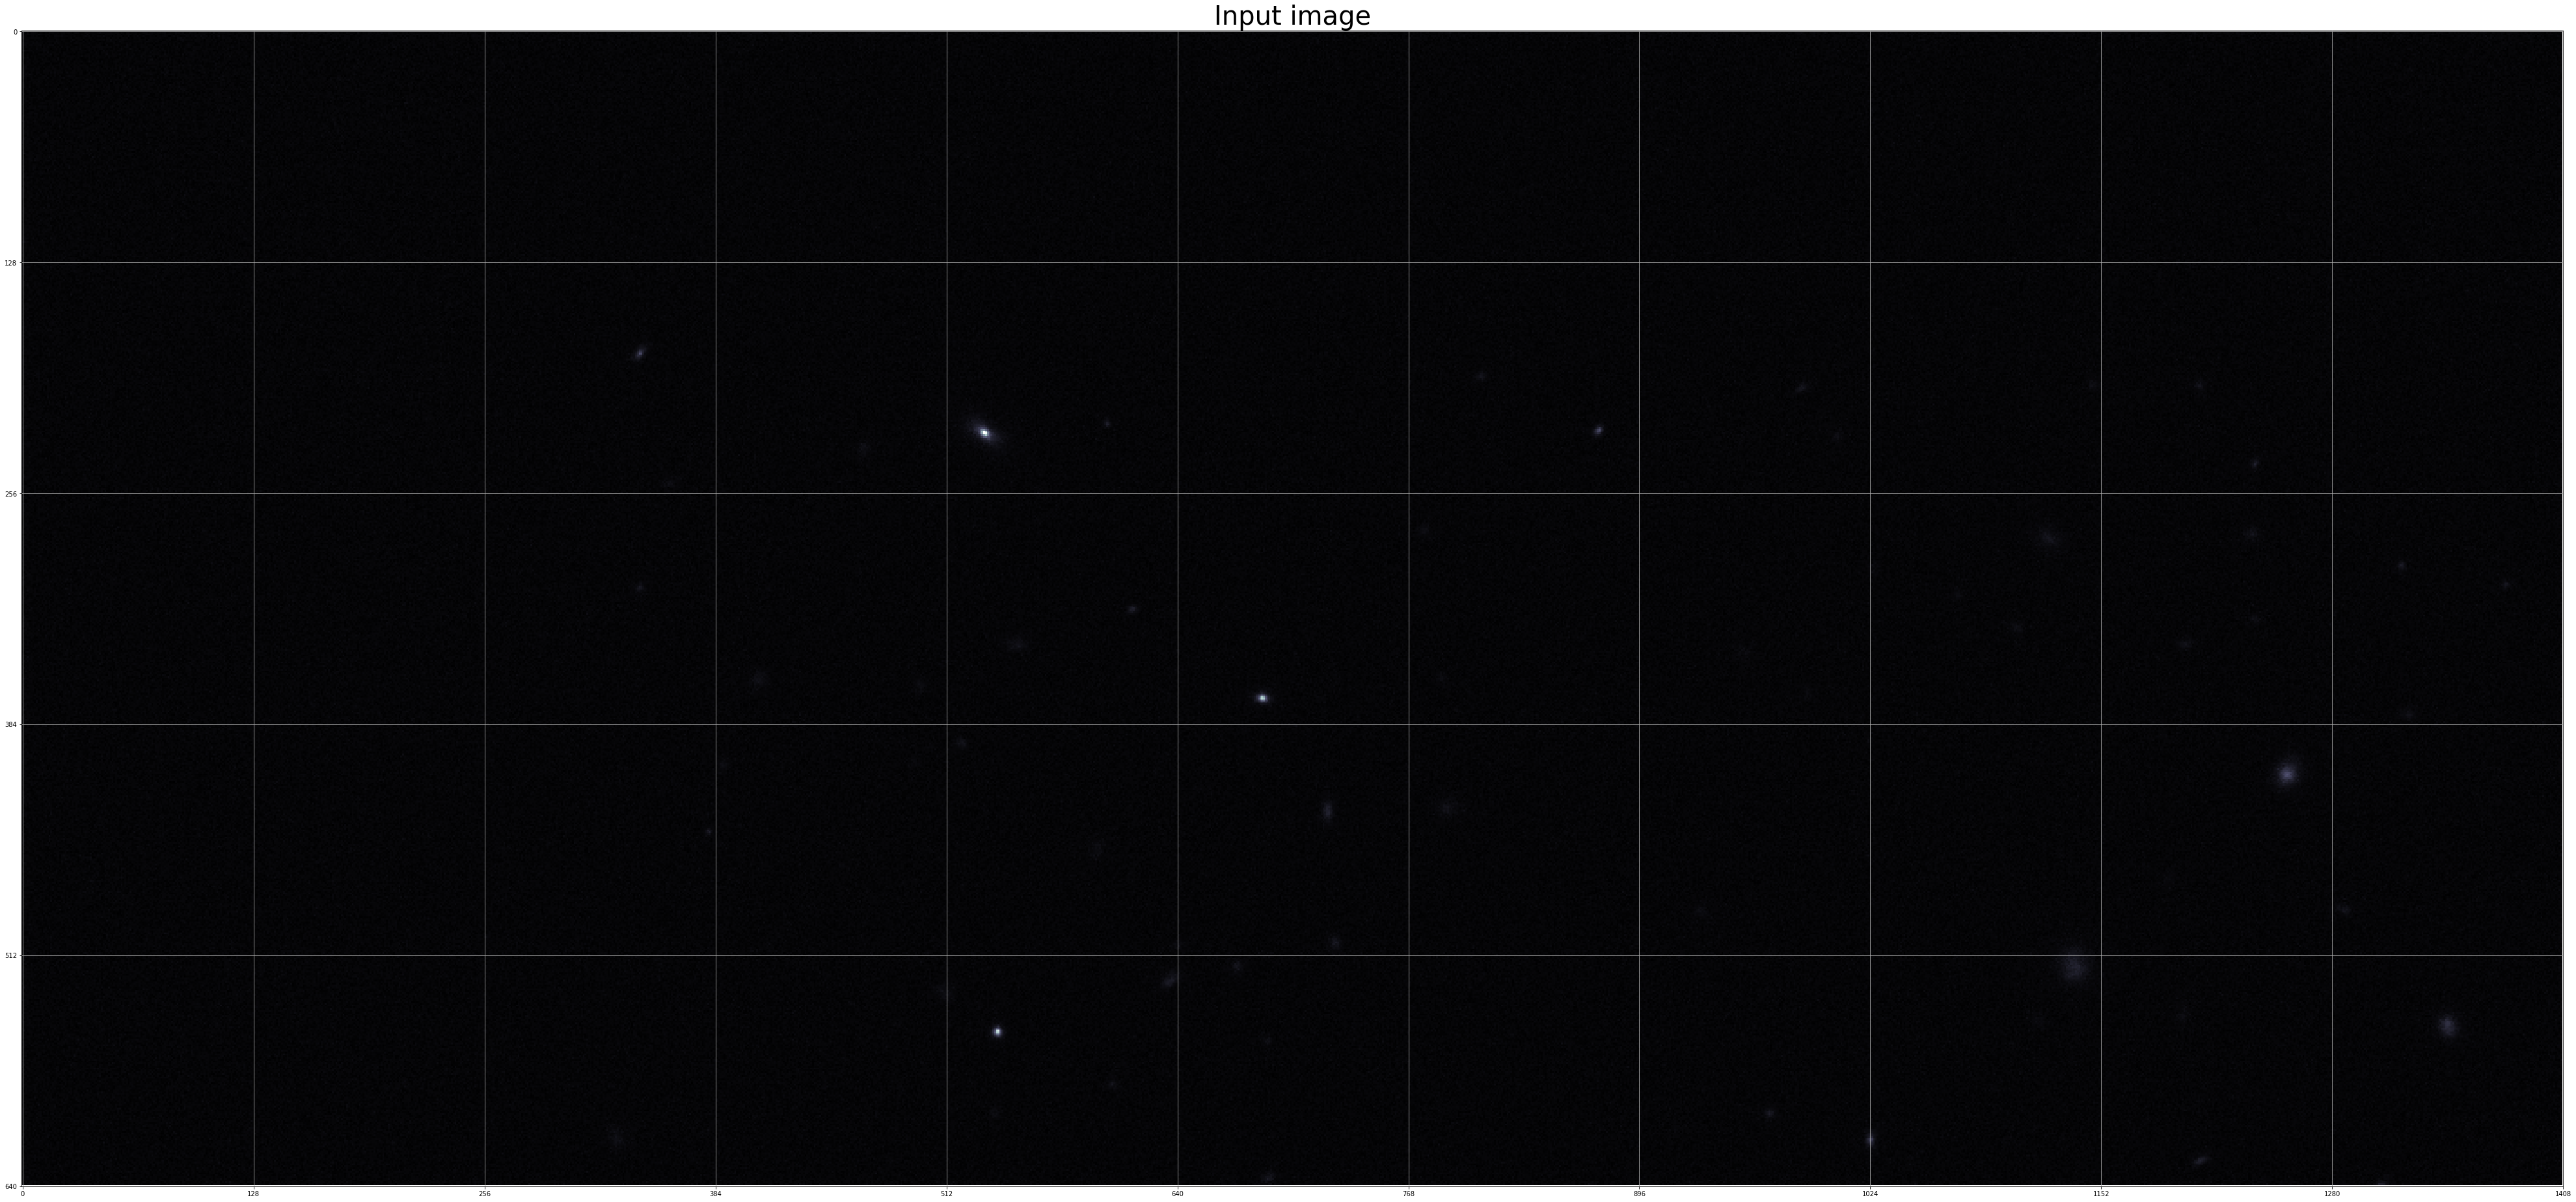

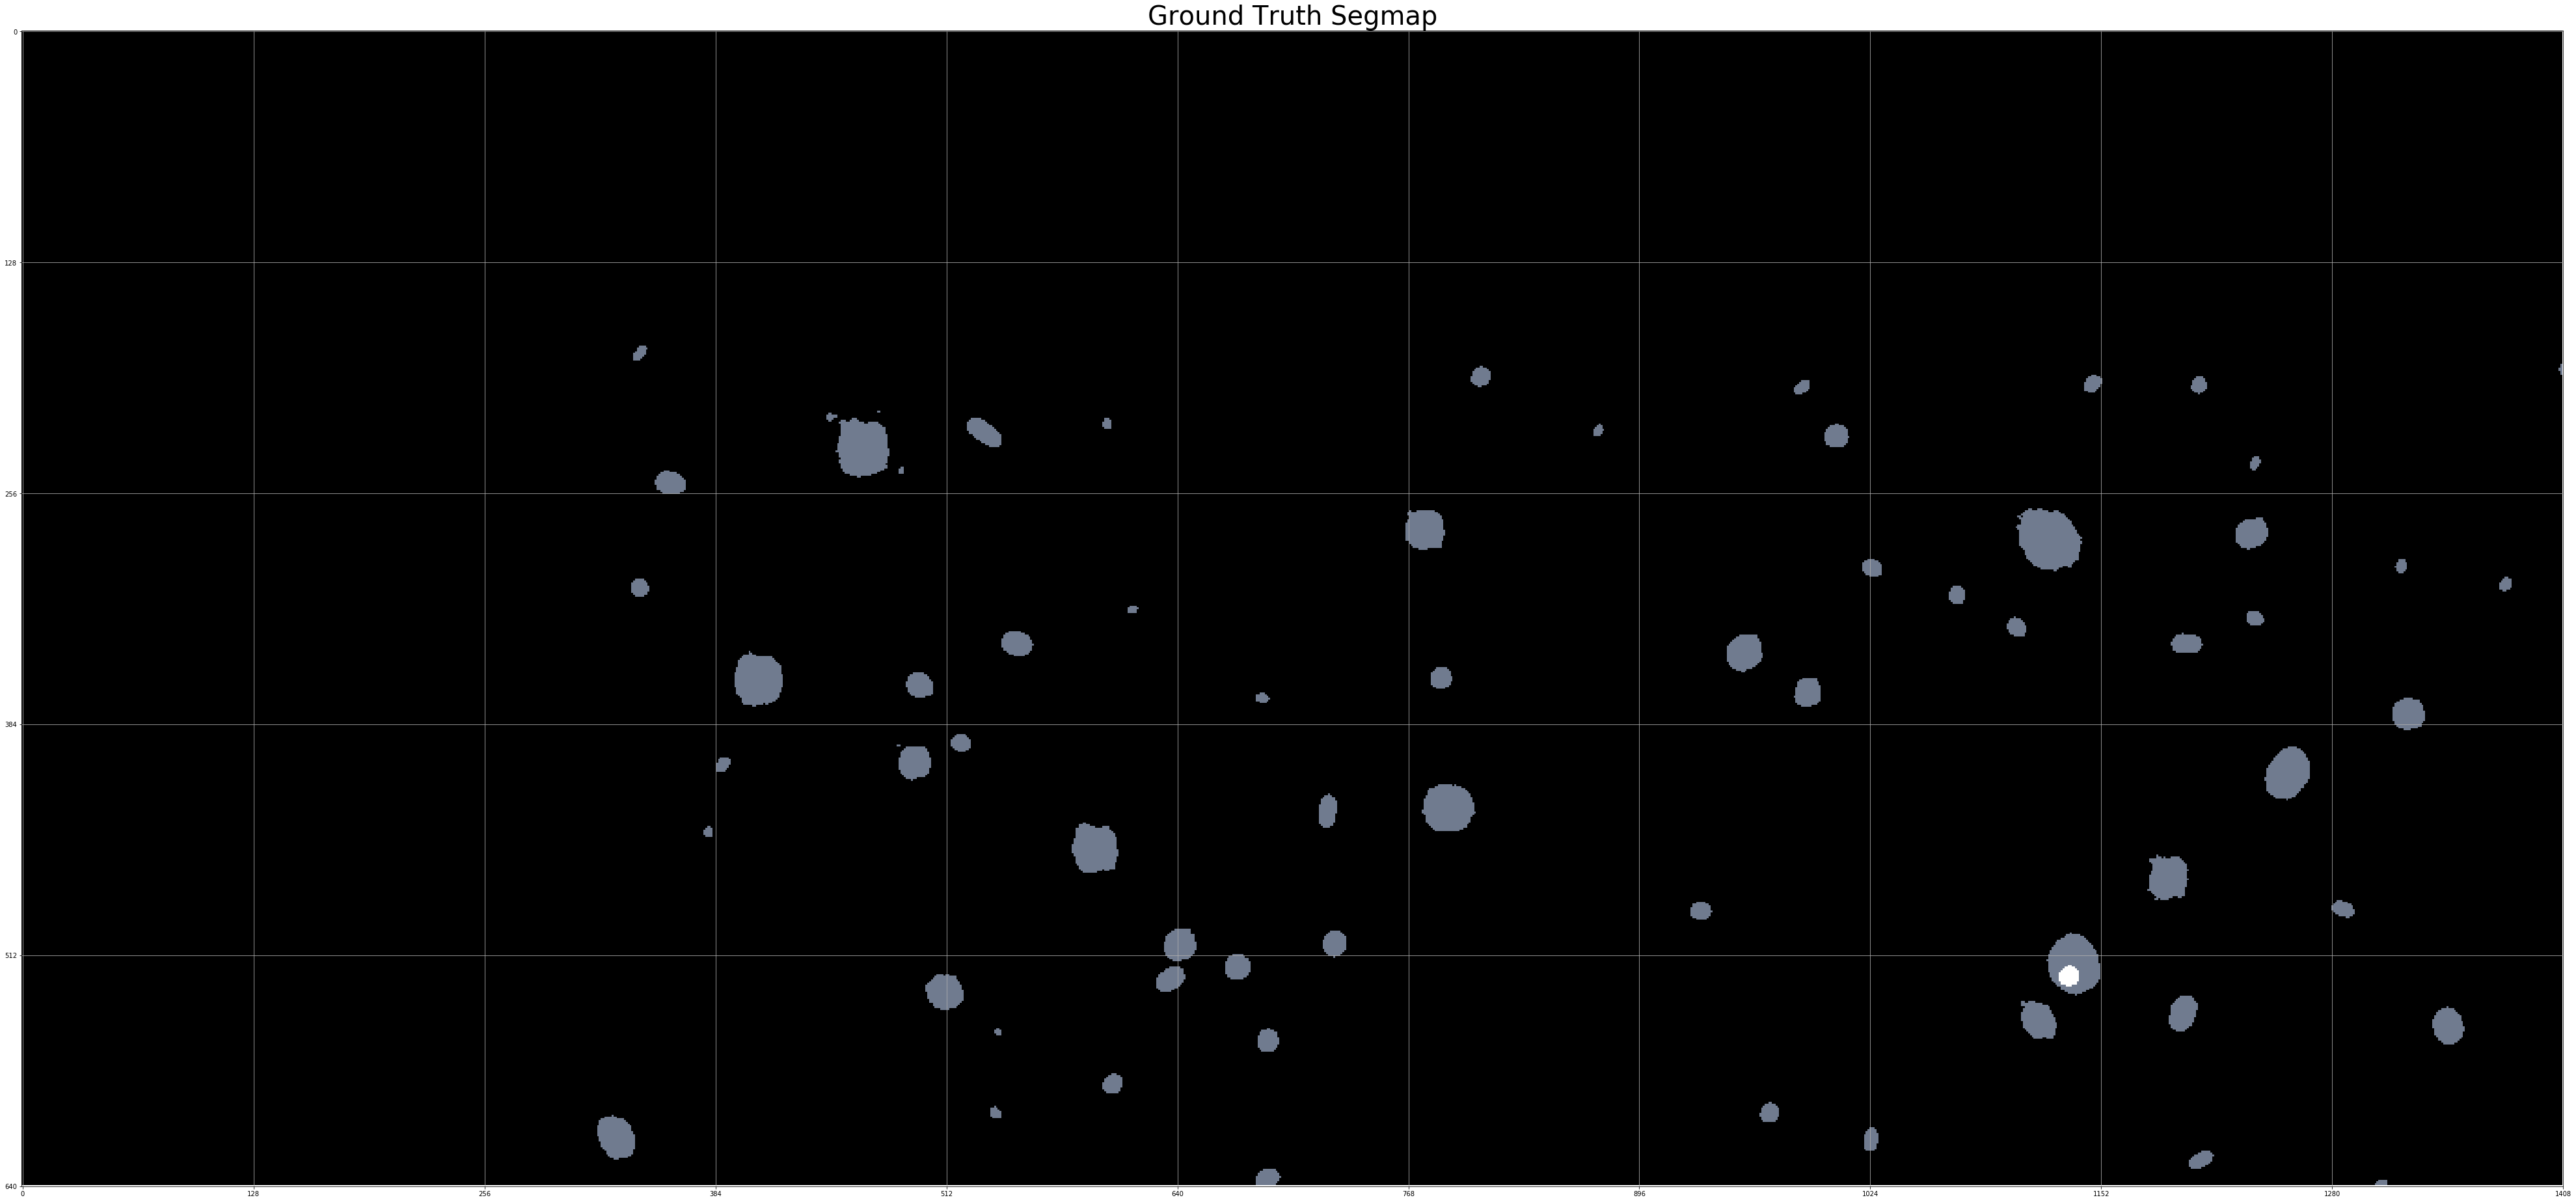

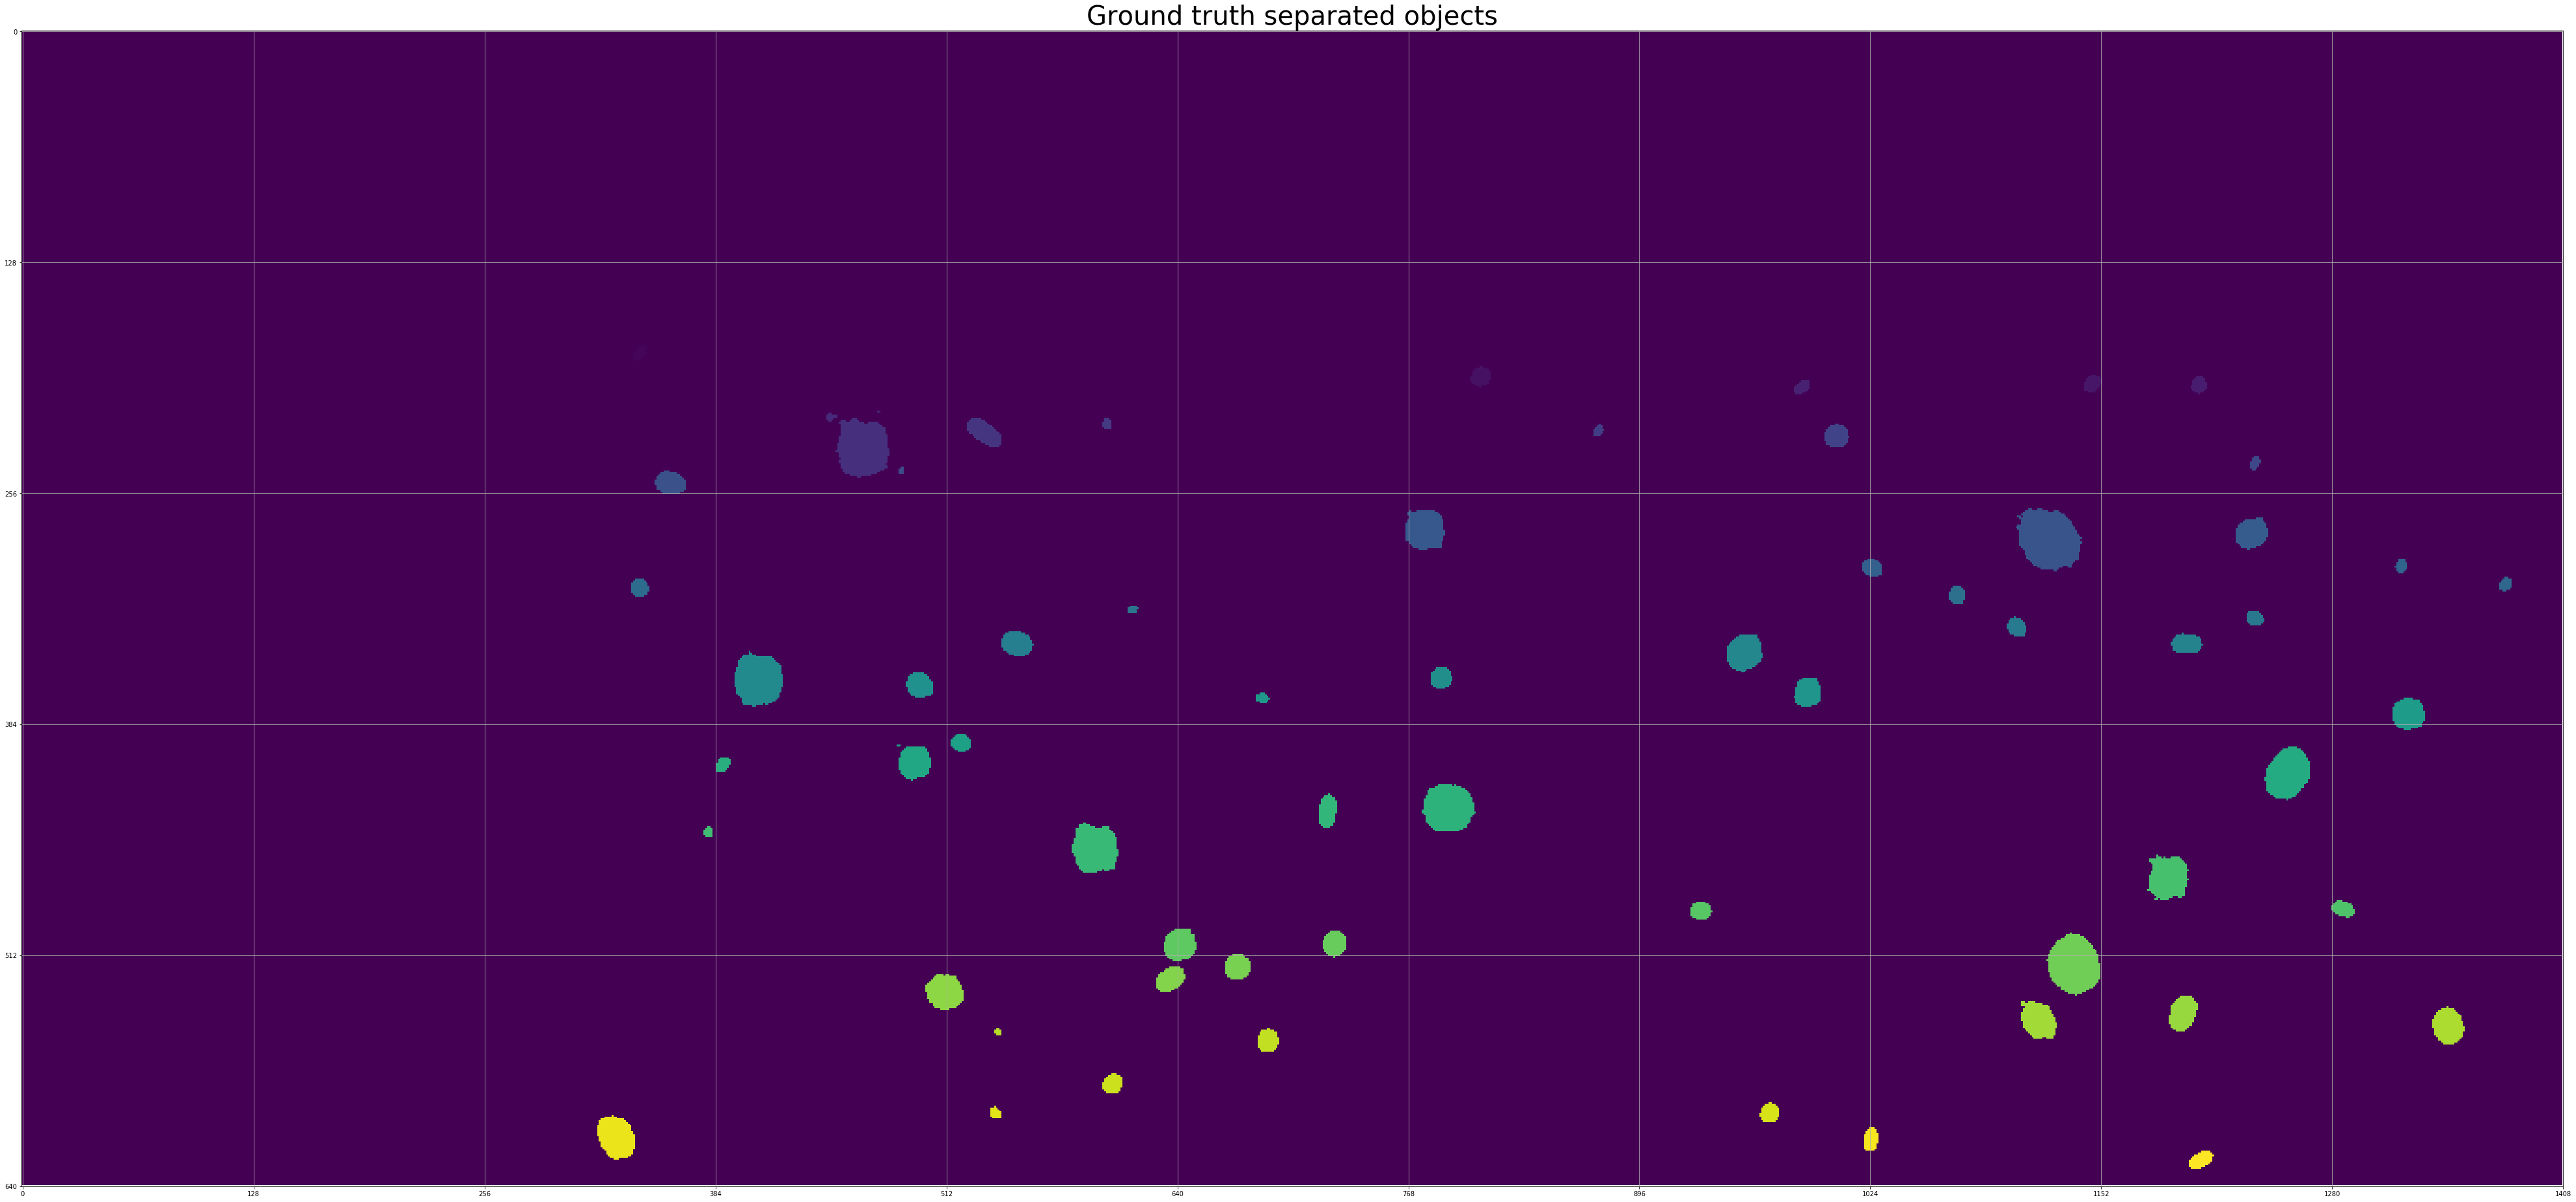

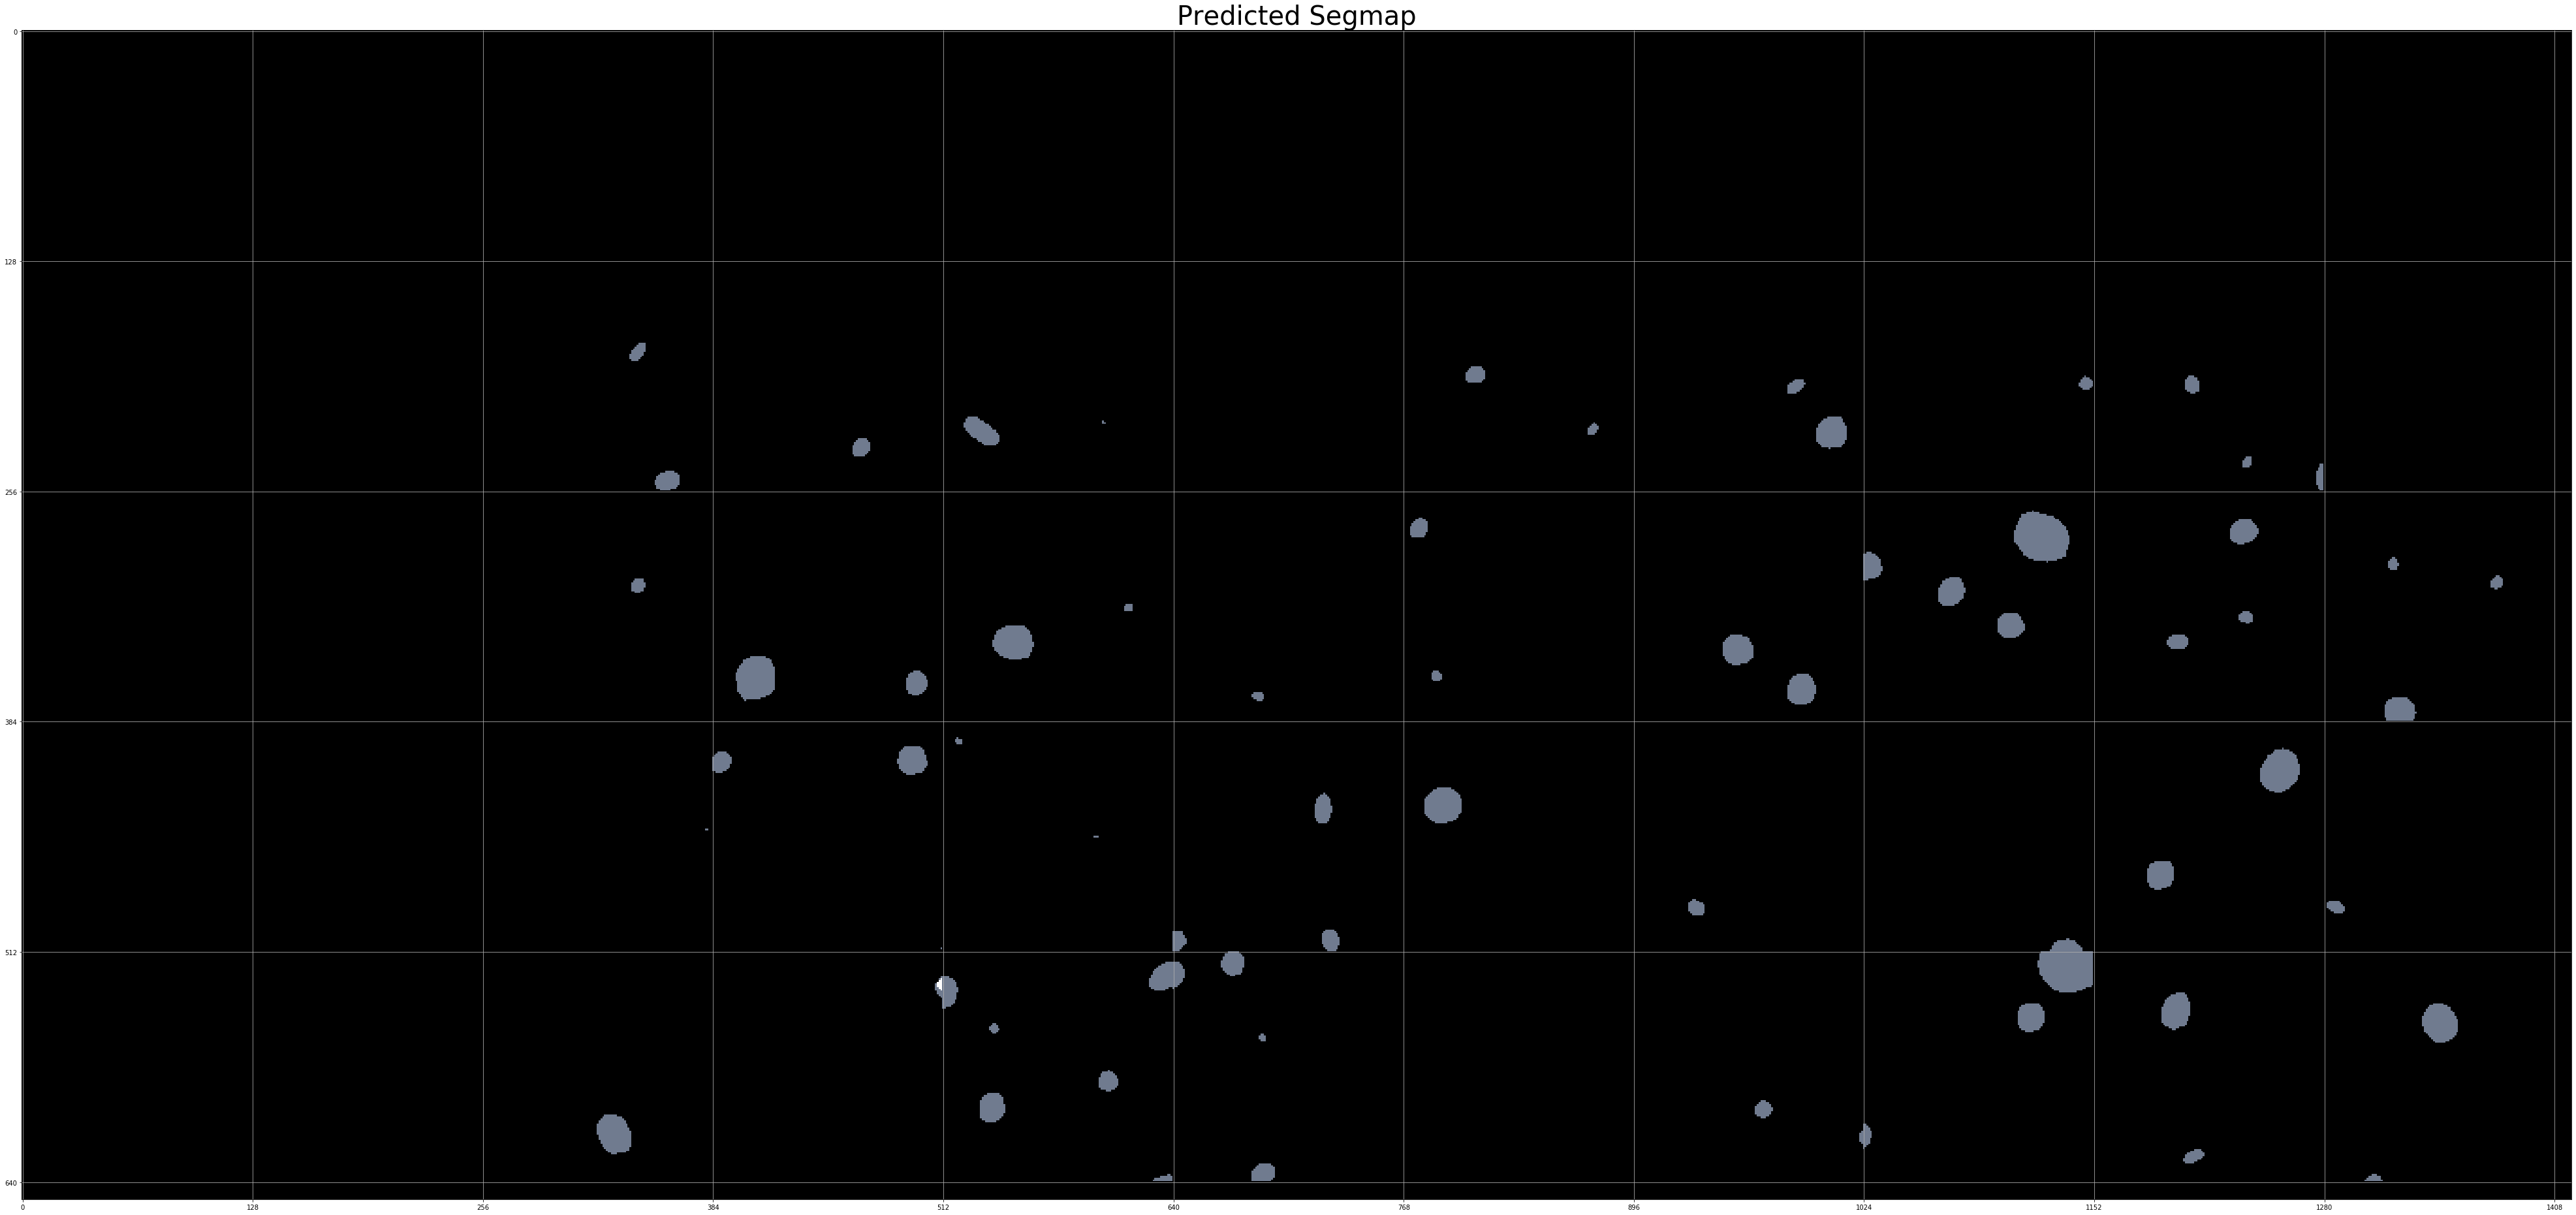

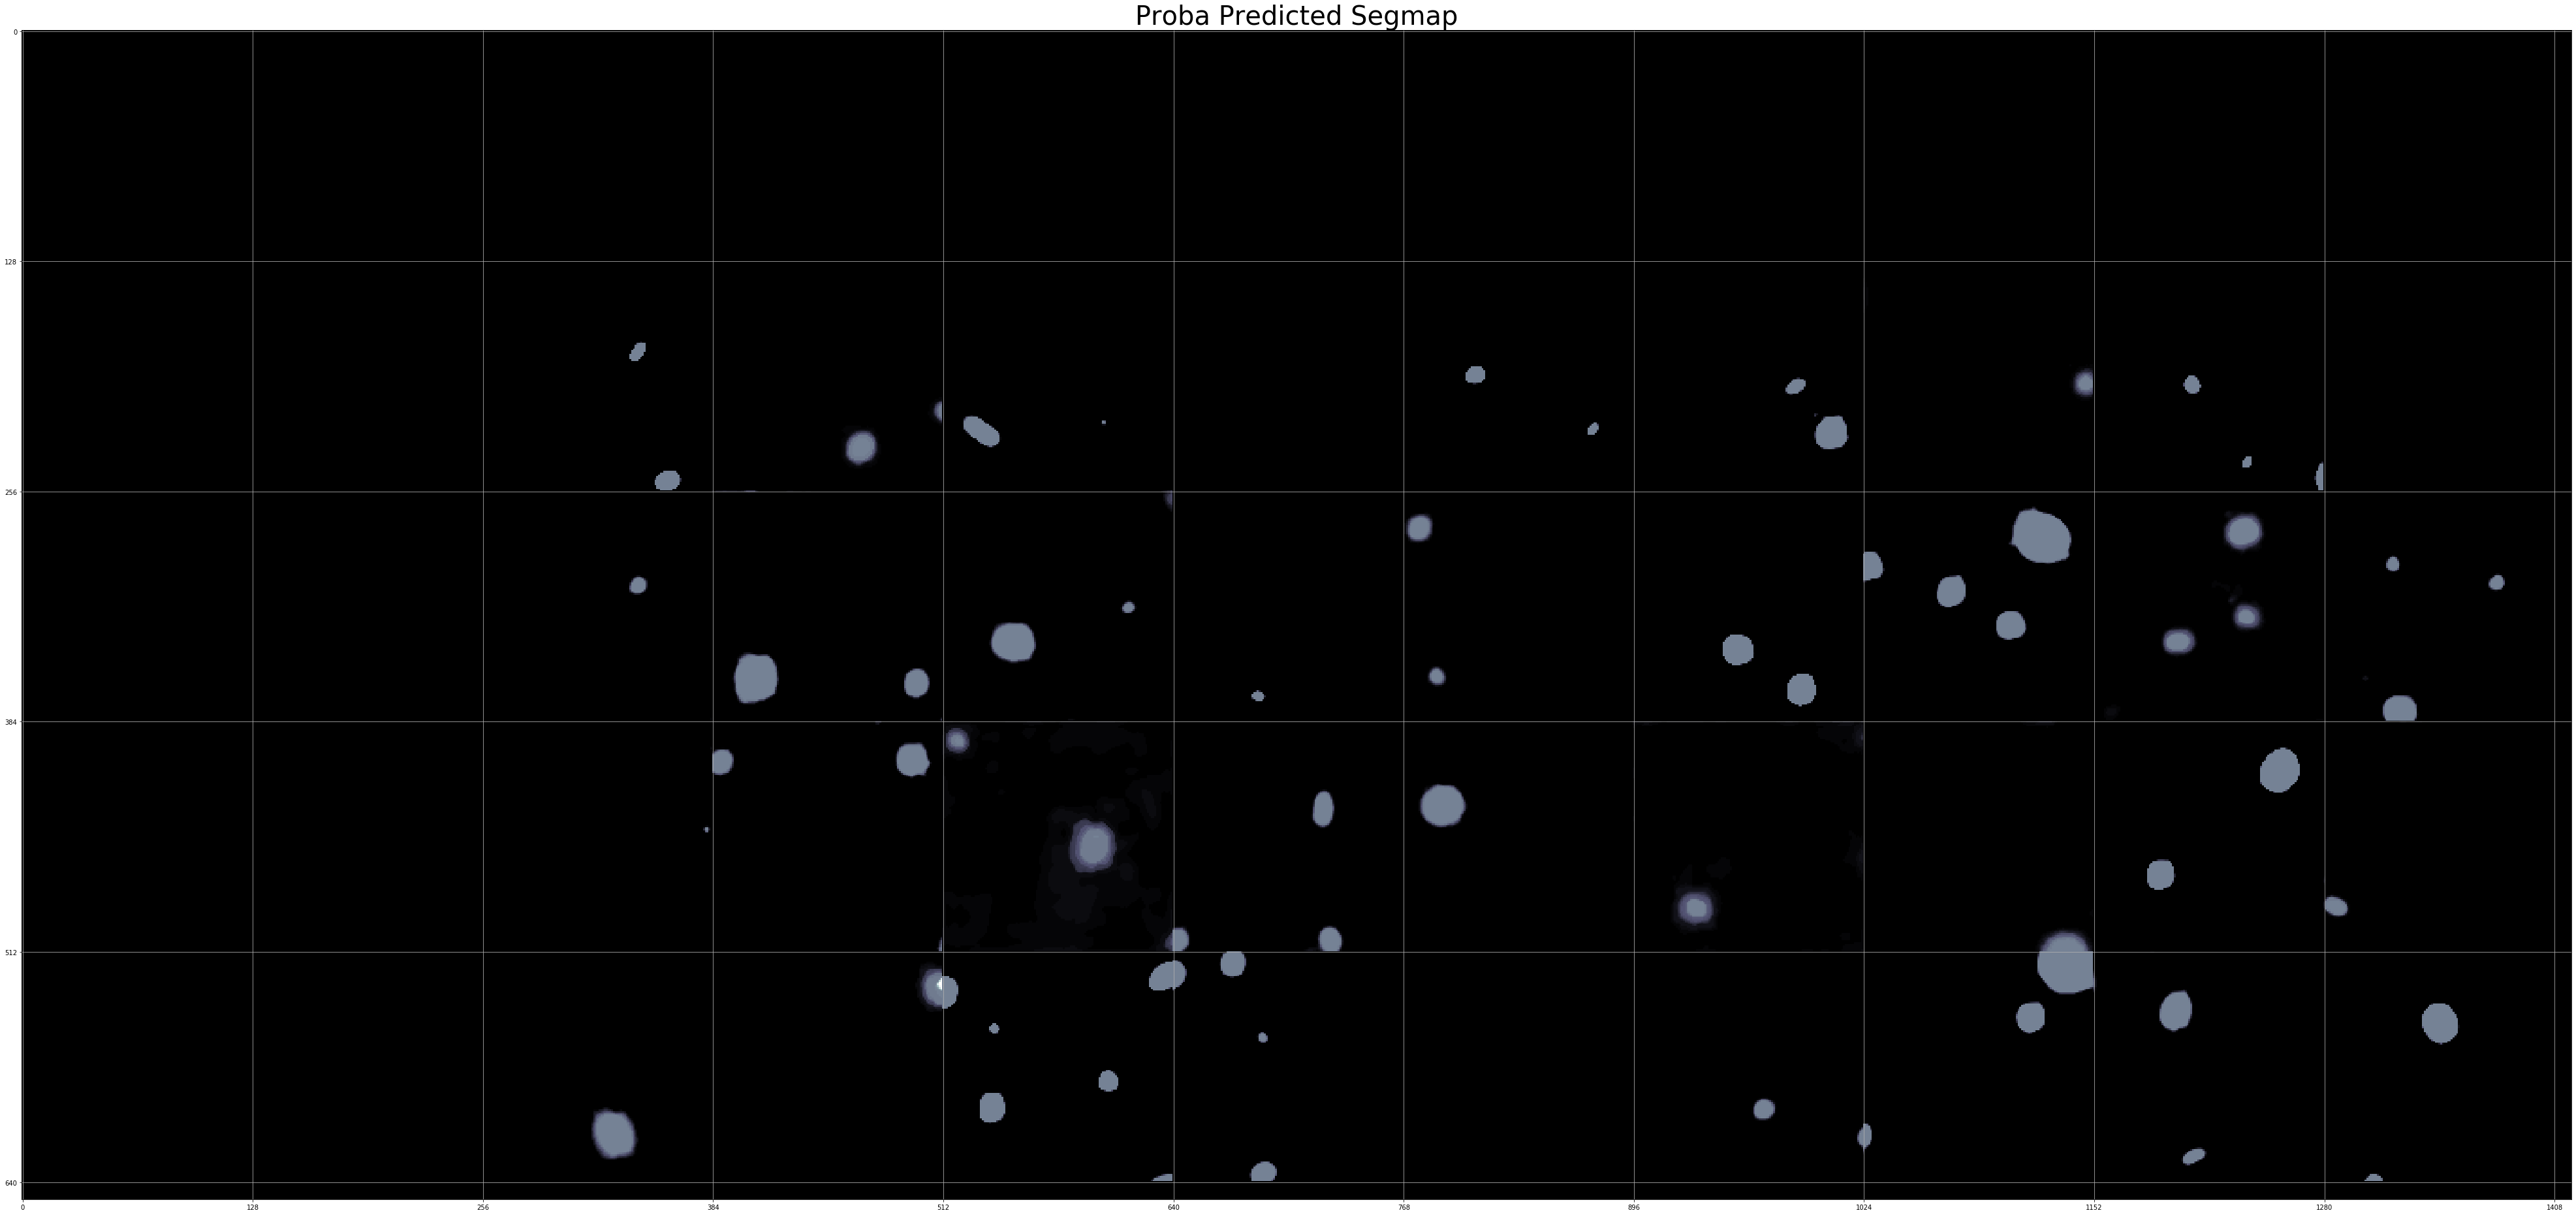

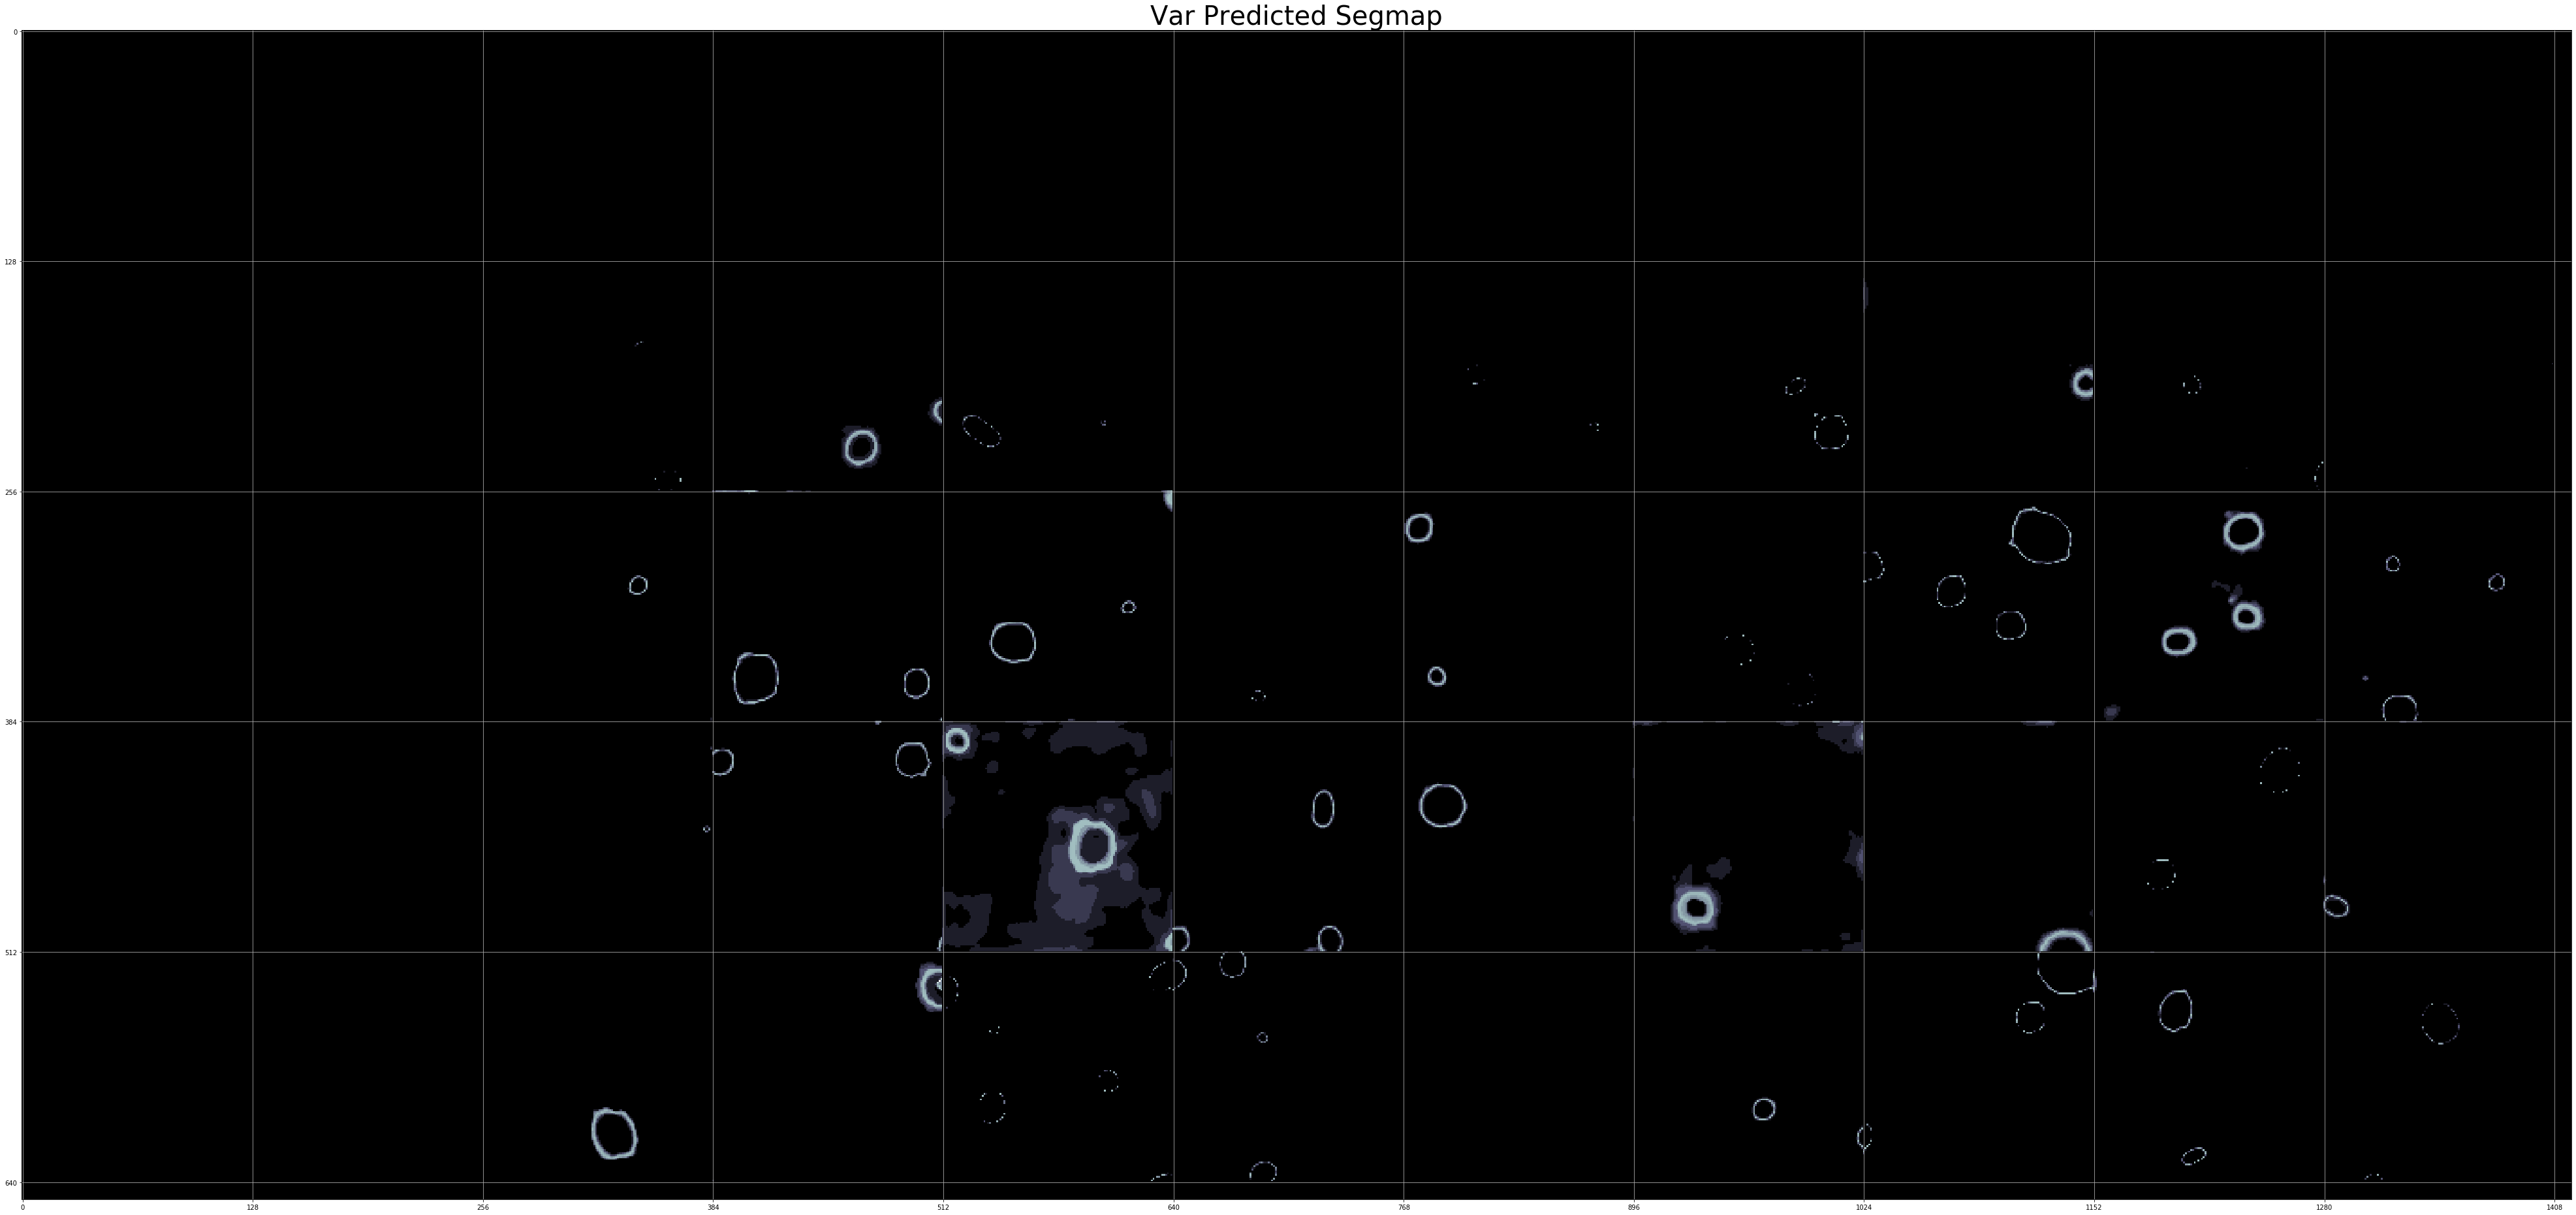

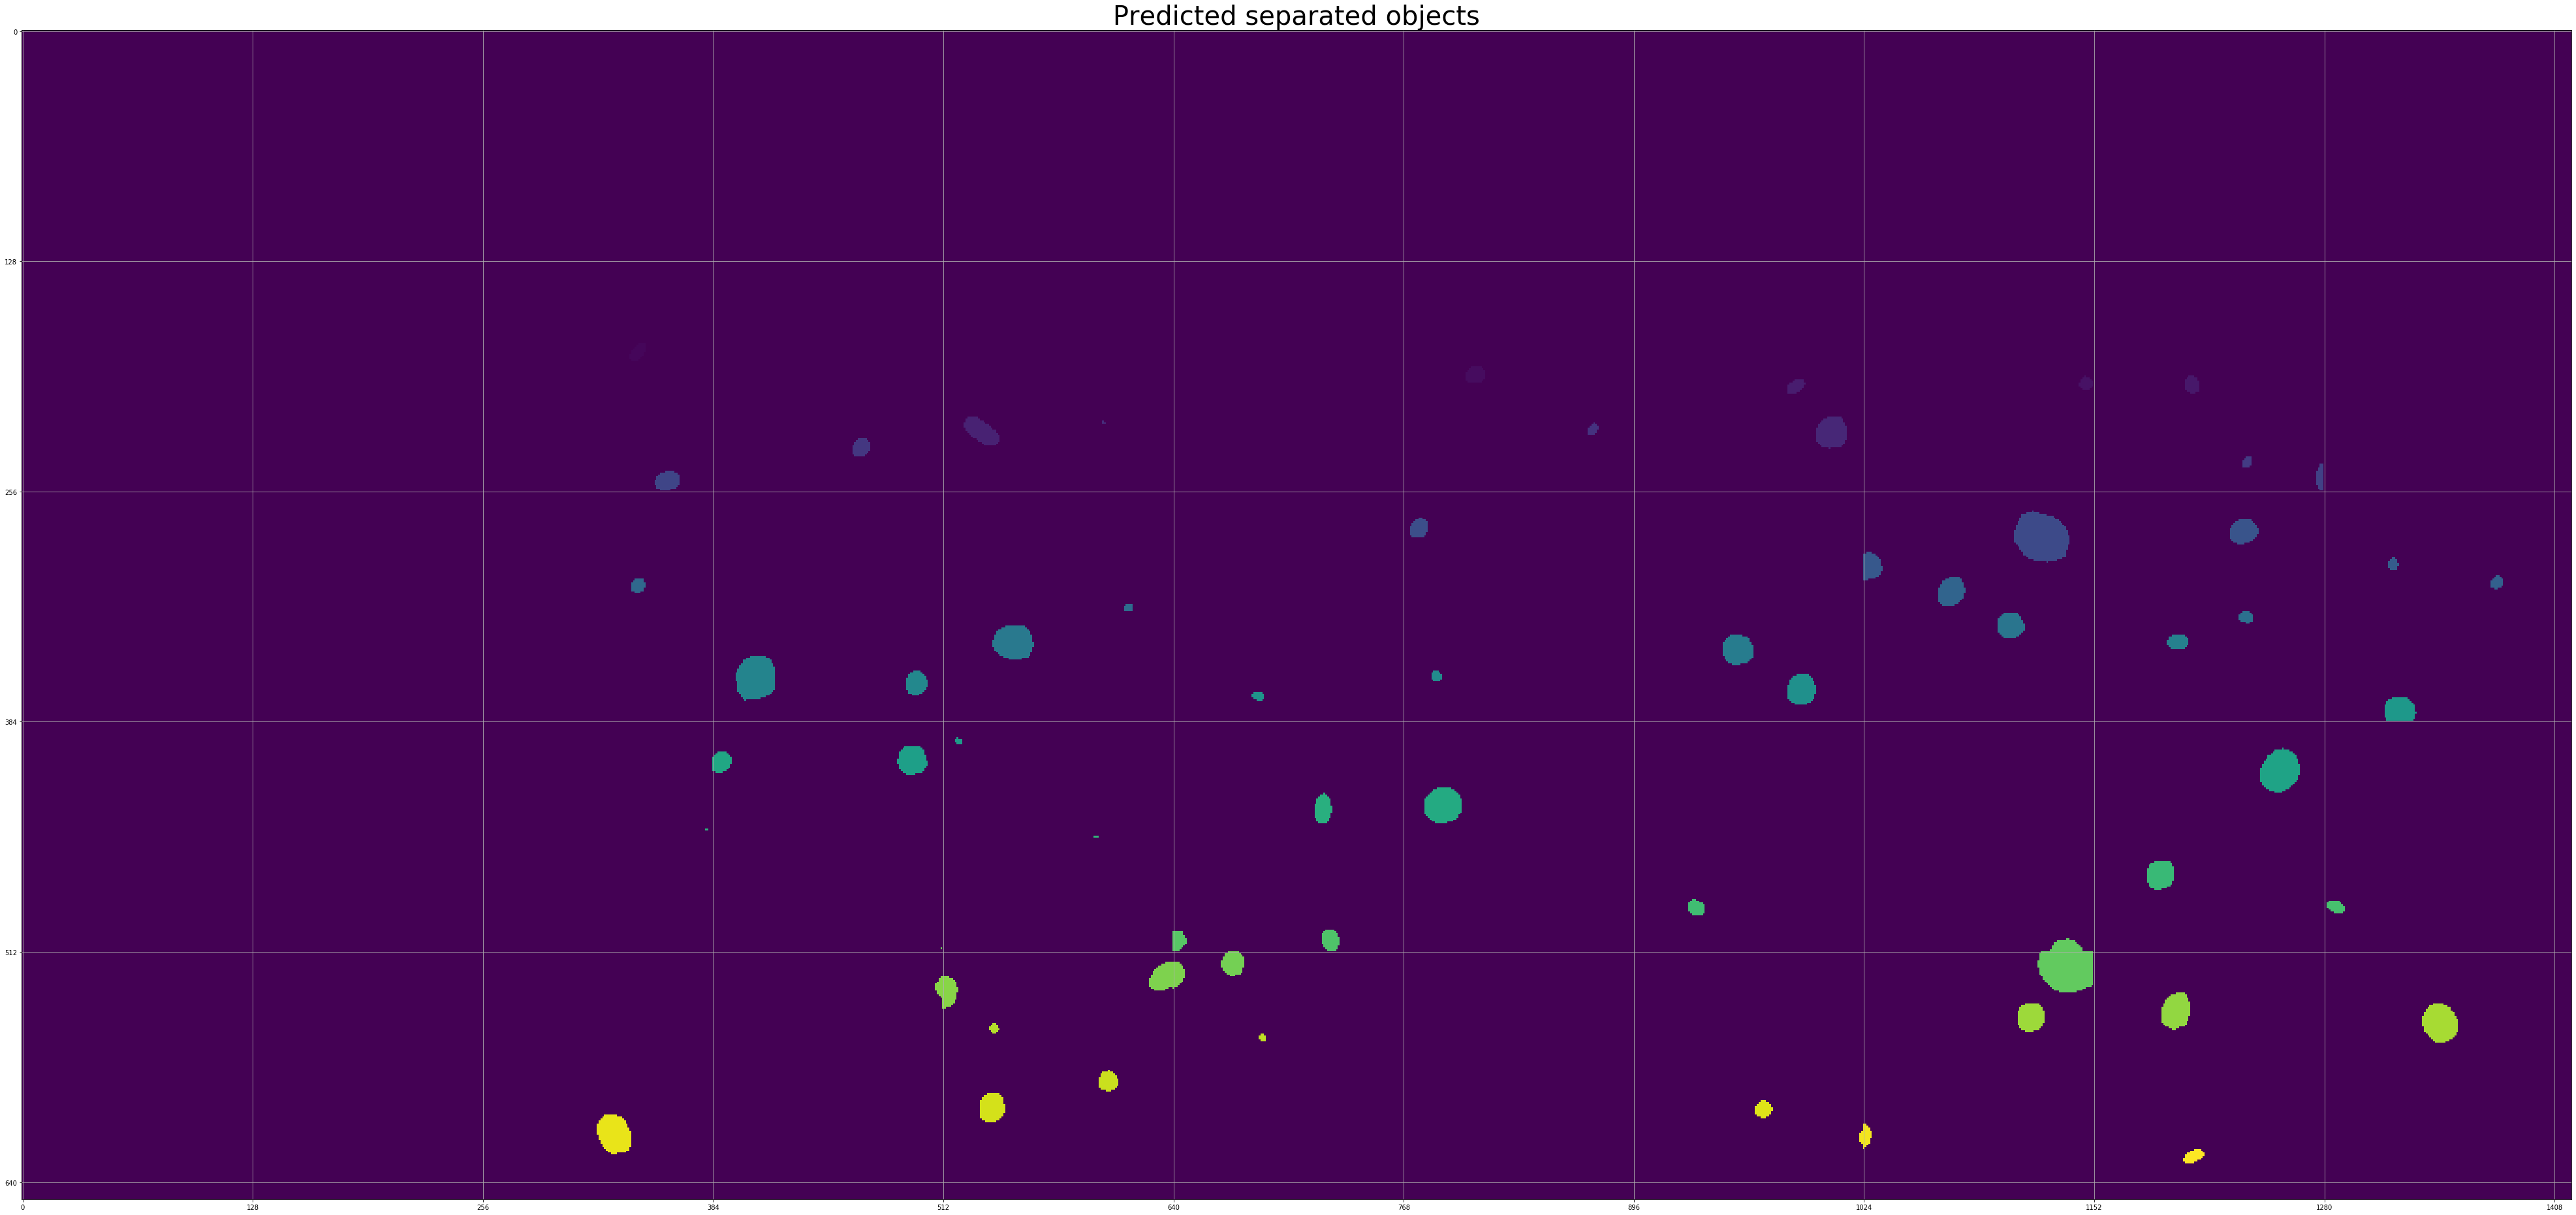

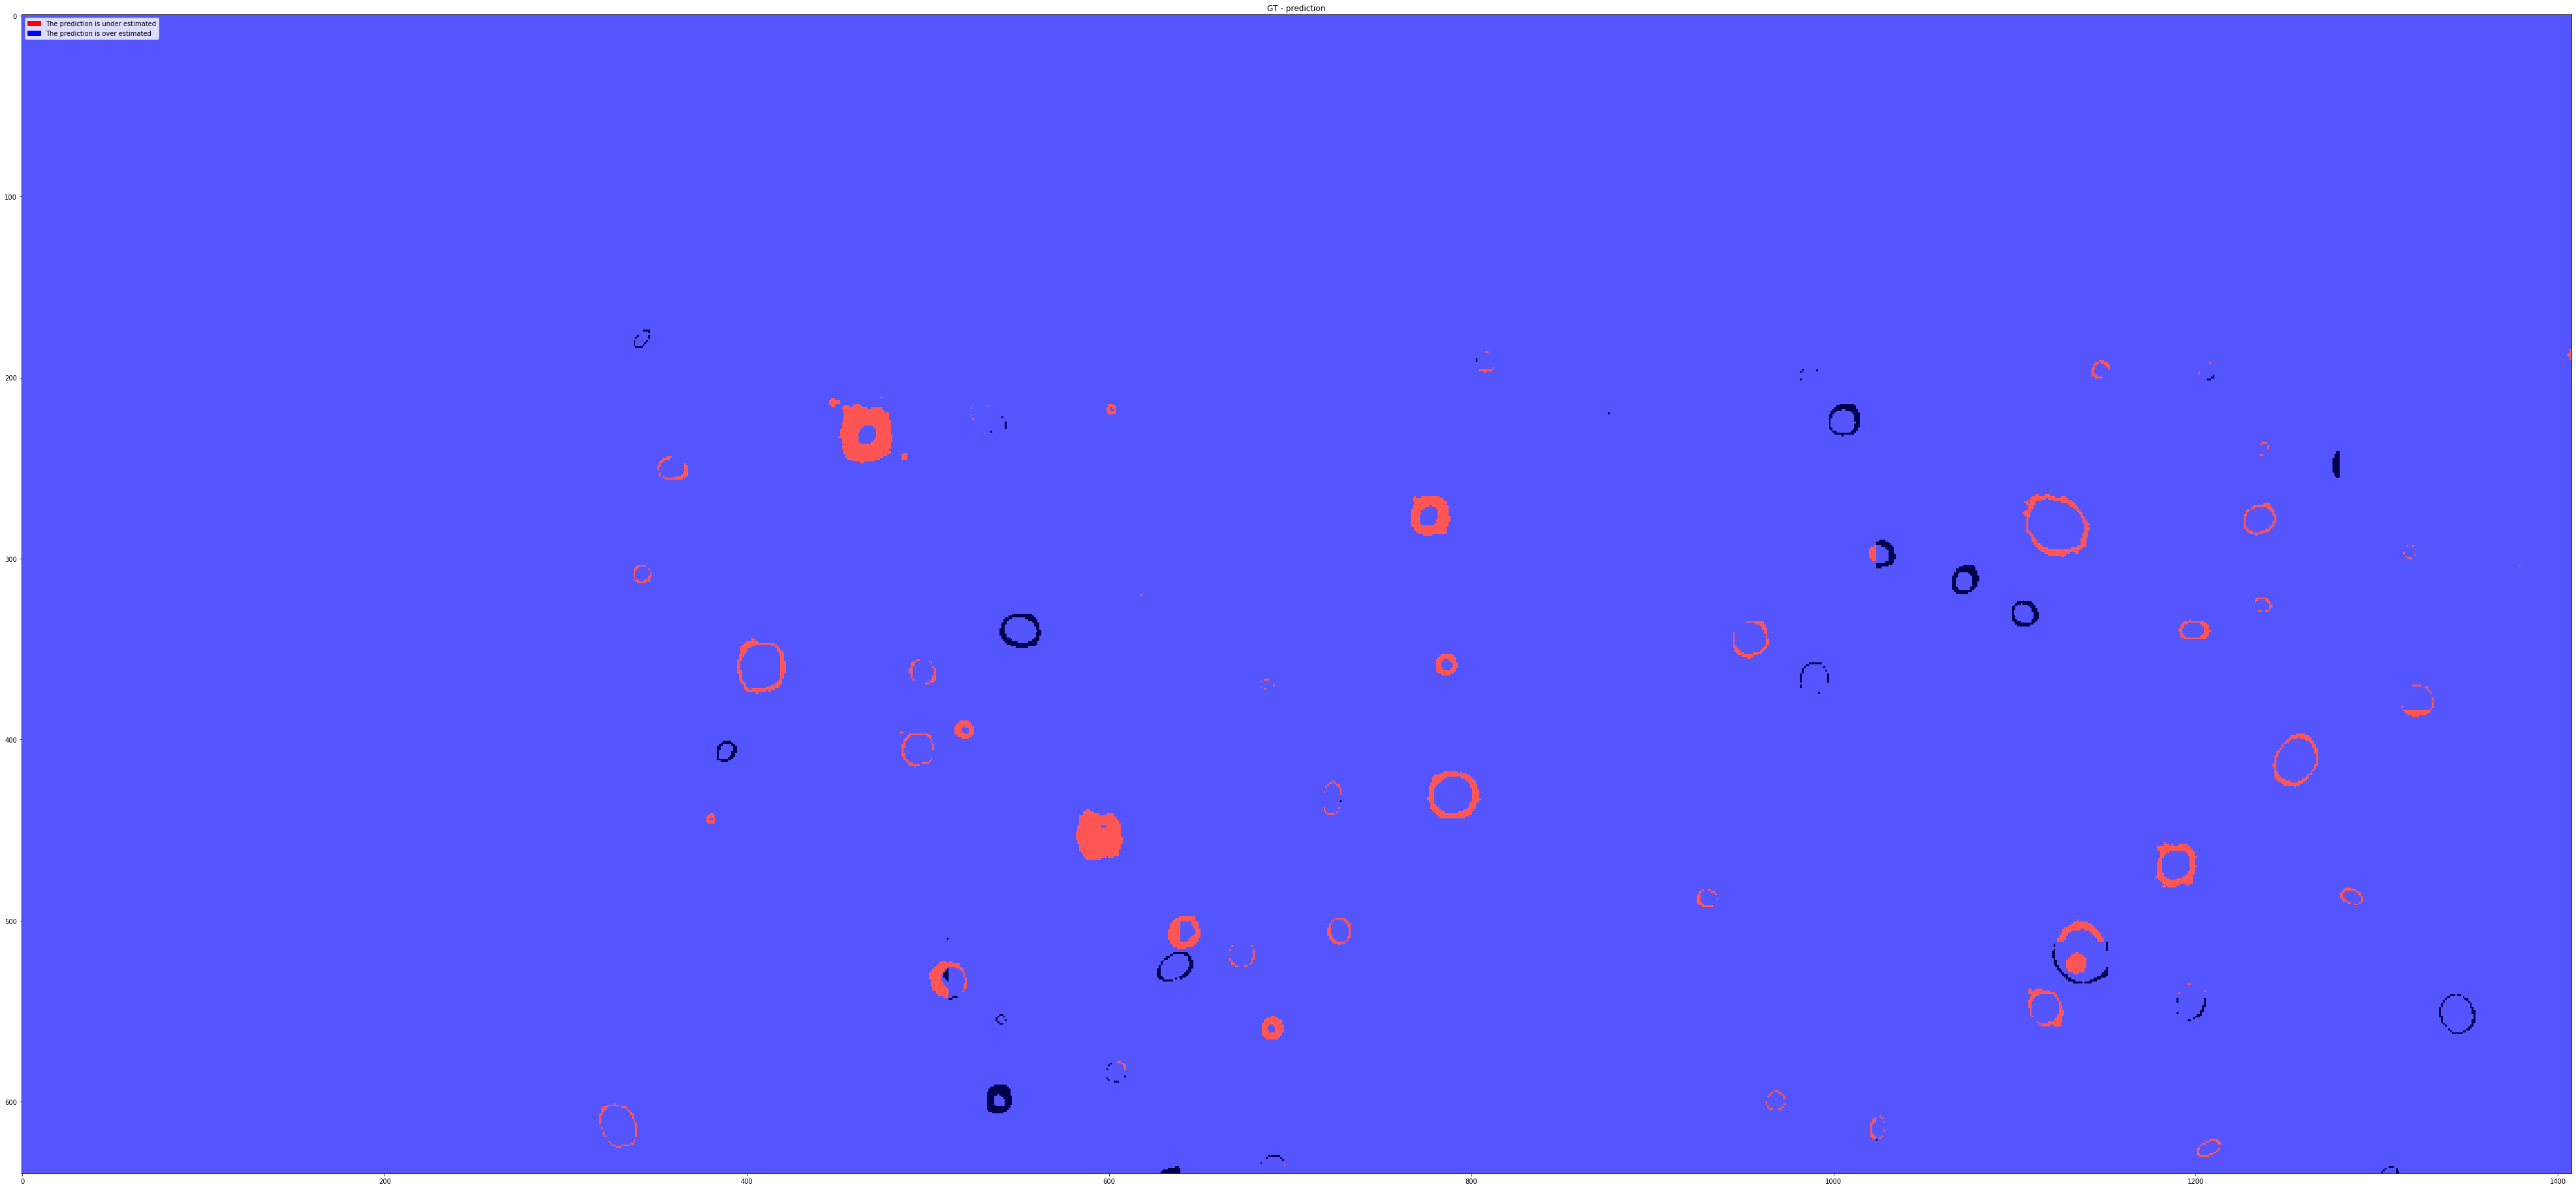

In [14]:
plot_maps(img, img_seg, gt_obj_map, big_rec_field_rough, pred_obj_map_rough, n_column, n_row, patch_size[0])

### Creation of the rough catalogue
See the dedicated notebook to see more information on how the cat is made

In [15]:
cat = pd.DataFrame(columns=['Index', 'Index_blend', 'x', 'y', 'loc', 'distance', 'area', 'area_blend', 'obj_status', 'blend_status', 'mag', 'rad', 'IOU', 'IOU_blend', 'var', 'var_blend'])
cat = cat.append(pd.Series(), ignore_index=True)
cat['Index'].iloc[-1] = "TU's index of the matching detected object"
cat['Index_blend'].iloc[-1] = "TU's index of the matching companion object"
cat['x'].iloc[-1] = "X coordinate on the big field"
cat['y'].iloc[-1] = "Y coordinate on the big field"
cat['loc'].iloc[-1] = "[xmin, xmax, ymin, ymax]"
cat['distance'].iloc[-1] = "Distance between the two object (computed on the TU cat)"
cat['area'].iloc[-1] = "# of pixel in the isolated object"
cat['area'].iloc[-1] = "# of pixel in the blended region"
cat['area_blend'].iloc[-1] = "# of pixel in the blended region"
cat['obj_status'].iloc[-1] = "TP/FP/FN"
cat['blend_status'].iloc[-1] = "TP/FP/FN"
cat['mag'].iloc[-1] = "Computed on the TU cat"
cat['rad'].iloc[-1] = "Computed on the TU cat"
cat['IOU'].iloc[-1] = "IOU on the iso region"
cat['IOU_blend'].iloc[-1] = "IOU on the blended region"
cat['var'].iloc[-1] = "dispersion of all the pixel 0 < x < 1 in the proba segmap"
cat['var_blend'].iloc[-1] = "dispersion of all the pixel 1 < x < 2 in the proba segmap"

cat

/obs/hbretonniere/miniconda3/envs/tf2gpu/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


,Index,Index_blend,x,y,loc,distance,area,area_blend,obj_status,blend_status,mag,rad,IOU,IOU_blend,var,var_blend
0,TU's index of the matching detected object,TU's index of the matching companion object,X coordinate on the big field,Y coordinate on the big field,"[xmin, xmax, ymin, ymax]",Distance between the two object (computed on t...,# of pixel in the blended region,# of pixel in the blended region,TP/FP/FN,TP/FP/FN,Computed on the TU cat,Computed on the TU cat,IOU on the iso region,IOU on the blended region,dispersion of all the pixel 0 < x < 1 in the p...,dispersion of all the pixel 1 < x < 2 in the p...


In [16]:
# add scheme of all the possibles classes

In [17]:
def produce_cat(img, gt, pred, gt_obj_map, pred_obj_map, gt_cat, is_score=True, is_show=None):

    cat = pd.DataFrame(columns=['TU_Index', 'TU_Index_blend', 'x', 'y', 'loc', 'distance', 'area', 'area_blend', 'obj_status', 'blend_status', 'mag', 'rad', 'IOU', 'IOU_blend', 'var', 'var_blend'])
    sz = 80            # size of the stamp to compute the IOU on
    mid = 40           # sz/2
    index_cat = -1     # index_catof the object in the catalogue
    dr = 5             # epsilon to try to match the galaxy in the catalogue
    index_label = 1    # object number in th e measure.label image
    no_match = 0 
    seen_ = 0          # When 
    pb = 0
    plot = 0           # Number of object that have been plotted

    while index_label <= pred_obj_map.max():
        if index_label % 100 ==0:
            print(f'index_label ={index_label}')
        index_cat += 1

        '''create the stamp of the objects'''
        pred_obj_stamp = np.zeros((3, sz, sz))
        gt_stamp = np.zeros((sz, sz))

        try:
            '''detect the index_label-th object'''
            a_pred = np.where(pred_obj_map == index_label)      # coords of all the pixels belonging to the index_labelth object
            if len(a_pred[0]) == 0:
                print(f"{index_label}-th object is null")
                index_label += 1
                continue
            sizex, sizey = a_pred[0].max()+1 - a_pred[0].min(), a_pred[1].max()+1 -a_pred[1].min()   # corresponding size of the galaxy (square)

            cat = cat.append(pd.Series(), ignore_index=True)  #add a new line to our pred catalogue

            ''' Add the location to the catalogue to do the better detection'''
            cat['loc'].iloc[-1] = [a_pred[0].min(), a_pred[0].max(), a_pred[1].min(), a_pred[1].max()]

            ''' Add the coords to the catalogue (for now, the centroid is just the middle of the stamp)'''
            cat['x'].iloc[-1] = int(np.mean(a_pred[0]))
            cat['y'].iloc[-1] = int(np.mean(a_pred[1]))

            ''' Add the area to the catalogue '''
            cat['area'].iloc[-1] = [int(len(a_pred[0])), None]
            
            # We pass the score calculation if we just want to do the rough detection
            if not is_score :
                index_label += 1
                continue
                
            ''' Place the detected object in the center of the new stamp for calculus'''
            pred_obj_stamp[:, int(mid-sizex/2):int(mid+sizex/2), int(mid-sizey/2):int(mid+sizey/2)] = pred[:, a_pred[0].min():a_pred[0].max()+1, a_pred[1].min():a_pred[1].max()+1]
            cat['area_blend'].iloc[-1] = [int(len(np.where(pred_obj_stamp[0]==2)[0])), None]

            ''' Macth the object(s) of the TU catalogue : we look in x+/-dr, y+-dr and see if there is a galaxy 
                in this interval in the TU cat (x/y are inverted compared to numpy...) '''

            indexes_tu = np.where((gt_cat[:, 3] > a_pred[0].min()- dr) & (gt_cat[:, 3] < a_pred[0].max()+dr) & (gt_cat[:, 2] > a_pred[1].min()-dr) & (gt_cat[:, 2] < a_pred[1].max()+dr))[0]

            if len(indexes_tu) == 0:      # there is no matching index
                index_tu = -1           # false positive

            else:
                index_tu = indexes_tu[0]

            ''' Add the Detection flag'''
            if index_tu == -1:      # False positive
                cat['obj_status'].iloc[-1] = 'FP'   # False positive for Detection flag
                index_label += 1
                if pred_obj_stamp.max() > 1:
                    cat['blend_status'].iloc[-1] = 'P'
                else:
                    cat['blend_status'].iloc[-1] = 'N'
                continue

            cat['obj_status'].iloc[-1] = 'TP'

            ''' Isolate the matching true object : same method but with the coordinates of the matching object '''

            a = np.where(gt_obj_map == gt_obj_map[int(gt_cat[index_tu, 3])-2:int(gt_cat[index_tu, 3])+2, int(gt_cat[index_tu, 2])-2:int(gt_cat[index_tu, 2])+2].max())
    #             print('2', a[0].min(), a[0].max())
            if gt_obj_map[int(gt_cat[index_tu, 3])-2:int(gt_cat[index_tu, 3])+2, int(gt_cat[index_tu, 2])-2:int(gt_cat[index_tu, 2])+2].max() == 0:
                print(" Matching object does not exist")
                cat = cat.drop(cat.shape[0]-1, 0)
                index_label += 1
                no_match += 1
                continue

            sizex = a[0].max()+1 -a[0].min()
            sizey = a[1].max()+1 -a[1].min()

    #             gt_stamp[int(mid-sizex/2):int(mid+sizex/2), int(mid-sizey/2):int(mid+sizey/2)] = gt_obj_map[a[0].min():a[0].max()+1, a[1].min():a[1].max()+1]
            gt_stamp[int(mid-sizex/2):int(mid+sizex/2), int(mid-sizey/2):int(mid+sizey/2)] = gt[a[0].min():a[0].max()+1, a[1].min():a[1].max()+1]

            cat['area'].iloc[-1][1] = int(len(a[0]))
            cat['area_blend'].iloc[-1][1] = int(len(np.where(gt_stamp == 2)[0]))

            '''Checindex_label if the object is a TP(1)/FP(2)/TN(3)/FN(4) blend'''

            if gt_stamp.max() > 1 and pred_obj_stamp[0].max() > 1:
                cat['blend_status'].iloc[-1] = 'TP'
                indexes_tu = np.where((gt_cat[:, 3] > a[0].min()) & (gt_cat[:, 3] < a[0].max()) & (gt_cat[:, 2] > a[1].min()) & (gt_cat[:, 2] < a[1].max()))[0]
                cat['TU_Index'].iloc[-1] = int(gt_cat[indexes_tu[0], 0])
                cat['TU_Index_blend'].iloc[-1] = int(gt_cat[indexes_tu[1], 0])
                cat['mag'].iloc[-1] = round(gt_cat[indexes_tu[0], 4], 4)
                cat['rad'].iloc[-1] = round(gt_cat[indexes_tu[0], 6], 4)
    #             index_label += 1
                cat['distance'] = round(np.sqrt((gt_cat[indexes_tu[0], 2] - gt_cat[indexes_tu[1], 2])**2 - (gt_cat[indexes_tu[0], 3] - gt_cat[indexes_tu[1], 3])**2), 4)

            if gt_stamp.max() == 1 and pred_obj_stamp[0].max() > 1:
                cat['TU_Index'].iloc[-1] = int(gt_cat[index_tu, 0])
#                     if measure.label(gt[a[0].min()-5:a[0].max()+1+5, a[1].min()-5:a[1].max()+1+5], connectivity=1).max() > 1:
#                         cat['blend_status'].iloc[-1] = 'TP_over_est'
                indexes_over_est = np.where((gt_cat[:, 3] > a_pred[0].min()) & (gt_cat[:, 3] < a_pred[0].max()) & (gt_cat[:, 2] > a_pred[1].min()) & (gt_cat[:, 2] < a_pred[1].max()))[0]
                if len(indexes_over_est) > 1:
                    cat['blend_status'].iloc[-1] = 'FP_over_est'
                else:
                    cat['blend_status'].iloc[-1] = 'FP'
                cat['mag'].iloc[-1] = round(gt_cat[index_tu, 4], 4)
                cat['rad'].iloc[-1] = round(gt_cat[index_tu, 6], 4)
    #             index_label += 1
            if gt_stamp.max() == 1 and pred_obj_stamp[0].max() == 1:
                cat['TU_Index'].iloc[-1] = int(gt_cat[index_tu, 0])
    #             print(tu_cat[index_tu, 4])
                cat['mag'].iloc[-1] = round(gt_cat[index_tu, 4], 4)
                cat['rad'].iloc[-1] = round(gt_cat[index_tu, 6], 4)
                cat['blend_status'].iloc[-1] = 'TN'
                blend_status = 'TN'
    #             index_label += 1
            if gt_stamp.max() > 1 and pred_obj_stamp[0].max() == 1:
                cat['blend_status'].iloc[-1] = 'FN'
                indexes_tu = np.where((gt_cat[:, 3] > a[0].min()- dr) & (gt_cat[:, 3] < a[0].max()+dr) & (gt_cat[:, 2] > a[1].min()-dr) & (gt_cat[:, 2] < a[1].max()+dr))[0]
                if gt_cat[indexes_tu[0],0] in cat['TU_Index'].values:
                    seen_ +=1
                    place = 1
                    other = 0
                else:
                    place = 0
                    other = 1
                cat['TU_Index'].iloc[-1] = int(gt_cat[indexes_tu[place], 0])
                cat['TU_Index_blend'].iloc[-1] = int(gt_cat[indexes_tu[other], 0])
                cat['mag'].iloc[-1] = round(gt_cat[indexes_tu[place], 4], 4)
                cat['rad'].iloc[-1] = round(gt_cat[indexes_tu[place], 6], 4)
                cat['distance'] = round(np.sqrt((gt_cat[indexes_tu[place], 2] - gt_cat[indexes_tu[other], 2])**2 + (gt_cat[indexes_tu[place], 3] - gt_cat[indexes_tu[other], 3])**2), 4)

            stamp_img = img[a[0].min()-50:a[0].max()+50, a[1].min()-50:a[1].max()+50]

            '''Compute the IOU'''
            if (cat['blend_status'].iloc[-1] == 'TP') or (cat['blend_status'].iloc[-1] == 'FP'):
                '''IOU not blended region'''
                wo_bacindex_labelground_obj = np.where(gt_stamp==0, np.max(gt_stamp) + 1, gt_stamp)
                wo_bacindex_labelground_obj = np.where(gt_stamp==2, 1, wo_bacindex_labelground_obj)

                wo_blend_pred = np.where(pred_obj_stamp == 2, 1, pred_obj_stamp)
                diff_obj = wo_bacindex_labelground_obj - wo_blend_pred
                intersection_obj = len(diff_obj[diff_obj==0])
                union_obj = len(np.where(wo_bacindex_labelground_obj[wo_bacindex_labelground_obj == 1])[0])\
                            + len(np.where(wo_blend_pred[wo_blend_pred == 1])[0])
                if union_obj == 0 :
                    IOU_obj = 'NaN'
                else :
                    IOU_obj = np.round(intersection_obj / union_obj,2)

                '''IOU blended region'''

                wo_bacindex_labelground_blend = np.where(((gt_stamp==0) | (gt_stamp == 1)), np.max(gt_stamp) + 1, gt_stamp)
                wo_isol_pred = np.where(pred_obj_stamp == 1, 0, pred_obj_stamp)
                diff_blend = wo_bacindex_labelground_blend - wo_isol_pred
                intersection_blend = len(diff_blend[diff_blend==0])
                union_blend = len(np.where(wo_bacindex_labelground_blend[wo_bacindex_labelground_blend == 2])[0])\
                            + len(np.where(wo_isol_pred[wo_isol_pred == 2])[0])
                if union_blend == 0 :
                    IOU_blend = 'NaN'
                else :
                    IOU_blend = round(intersection_blend / union_blend, 2)
                cat['IOU'].iloc[-1] = IOU_obj
                cat['IOU_blend'].iloc[-1] = IOU_blend

            else :
                #we put the bg to another value so it does not count in the well predicted pixels
                wo_bacindex_labelground = np.where(gt_stamp==0, np.max(gt_stamp) + 1, gt_stamp) 
                diff = wo_bacindex_labelground - pred_obj_stamp[0]
                intersection = len(np.where(diff==0)[0])
                union =  len(np.where((gt_stamp + pred_obj_stamp[0]) > 0)[0])
                if union == 0 :
                    IOU = 1
                else :
                    IOU = intersection / union
                cat['IOU'].iloc[-1] = round(IOU, 4)

            ''' Compute the variance '''

            cat['var'].iloc[-1] = round(np.mean(pred_obj_stamp[2, np.where((pred_obj_stamp[1] > 0) & (pred_obj_stamp[1] <= 1))[0], np.where((pred_obj_stamp[1] > 0) & (pred_obj_stamp[1] <= 1))[1]])
, 4)

            cat['var_blend'].iloc[-1] = round(np.mean(pred_obj_stamp[2, np.where((pred_obj_stamp[1] > 1) & (pred_obj_stamp[1] <= 2))[0], np.where((pred_obj_stamp[1] > 1) & (pred_obj_stamp[1] <= 2))[1]])
, 4)
            if pd.isnull(cat['var_blend'].iloc[-1]):
                cat['var_blend'].iloc[-1] = 0

            index_label += 1

            if is_show :
                if plot < 20 :
                    if (cat['blend_status'].iloc[-1] == 'TP'):

                        fig, ax = plt.subplots(1, 6, figsize=(10,50))
                        ax[0].imshow(pred_obj_stamp[0], vmax=2)
                        ax[0].title.set_text(f"Pred \n area:{cat['area'].iloc[-1][0]},{cat['area_blend'].iloc[-1][0]}")
                        ax[1].imshow(gt_stamp, vmax = 2)
                        ax[1].title.set_text(f"gt, dist {cat['distance'].iloc[-1]} \n area:{cat['area'].iloc[-1][1]},{cat['area_blend'].iloc[-1][1]}")
                        ax[2].imshow(diff_obj[0])
                        ax[2].title.set_text(f"dif no blend, \n IOU = {cat['IOU'].iloc[-1]}")
                        ax[3].imshow(diff_blend[1])
                        ax[3].title.set_text(f"dif blend, \n IOU = {cat['IOU_blend'].iloc[-1]}")
                        ax[4].imshow(pred_obj_stamp[2])
                        ax[4].title.set_text(f"var \n var blend = {cat['var_blend'].iloc[-1]} \n iso : {cat['var'].iloc[-1]}")
                        ax[5].imshow(stamp_img[int(stamp_img.shape[0]/2-32):int(stamp_img.shape[0]/2+32),int(stamp_img.shape[1]/2-32):int(stamp_img.shape[1]/2+32)])
                        ax[5].title.set_text(f"mag = {np.round(cat['mag'].iloc[-1]),2}")
                        plot += 1

                    if (cat['blend_status'].iloc[-1] == 'FP'):

                        fig, ax = plt.subplots(1, 6, figsize=(10,50))
                        ax[0].imshow(pred_obj_stamp[0], vmax=2)
                        ax[0].title.set_text(f"Pred \n area:{cat['area'].iloc[-1][0]},{cat['area_blend'].iloc[-1][0]}")
                        ax[1].imshow(gt_stamp, vmax = 2)
                        ax[1].title.set_text(f"gt, dist {cat['distance'].iloc[-1]} \n area:{cat['area'].iloc[-1][1]},{cat['area_blend'].iloc[-1][1]}")
                        ax[2].imshow(diff_obj[0])
                        ax[2].title.set_text(f"dif no blend, \n IOU = {cat['IOU'].iloc[-1]}")
                        ax[3].imshow(diff_blend[1])
                        ax[3].title.set_text(f"dif blend, \n IOU = {cat['IOU_blend'].iloc[-1]}")
                        ax[4].imshow(pred_obj_stamp[2])
                        ax[4].title.set_text(f"var \n var blend = {cat['var_blend'].iloc[-1]} \n iso : {cat['var'].iloc[-1]}")
                        ax[5].imshow(stamp_img[int(stamp_img.shape[0]/2-32):int(stamp_img.shape[0]/2+32),int(stamp_img.shape[1]/2-32):int(stamp_img.shape[1]/2+32)])
                        ax[5].title.set_text(f"mag = {np.round(cat['mag'].iloc[-1]),2}")
                        plot += 1

                    if cat['blend_status'].iloc[-1] ==  'FN':
                        fig, ax = plt.subplots(1, 5, figsize=(10,50))
                        ax[0].imshow(pred_obj_stamp[0], vmax=2)
                        ax[0].title.set_text(f"Pred \n area:{cat['area'].iloc[-1][0]},{cat['area_blend'].iloc[-1][0]}")
                        ax[1].imshow(gt_stamp, vmax = 2)
                        ax[1].title.set_text(f"gt, dist {cat['distance'].iloc[-1]} \n area:{cat['area'].iloc[-1][1]},{cat['area_blend'].iloc[-1][1]}")
                        ax[2].imshow(diff)
                        ax[2].title.set_text(f"dif, \n IOU = {cat['IOU'].iloc[-1]}")
                        ax[3].imshow(pred_obj_stamp[2])
                        ax[3].title.set_text(f" iso : {cat['var'].iloc[-1]}")
                        ax[4].imshow(stamp_img[int(stamp_img.shape[0]/2-32):int(stamp_img.shape[0]/2+32),int(stamp_img.shape[1]/2-32):int(stamp_img.shape[1]/2+32)])
                        ax[4].title.set_text(f"mag = {np.round(cat['mag'].iloc[-1]),2}")
                        plot += 1


        except:
                print("Unexpected error")
                cat = cat.drop(cat.shape[0]-1, 0)
                index_label += 1
                pb += 1
    print(f'there is {no_match} not matching object')
    return cat, no_match

In [18]:
cat_rough, no_match = produce_cat(img, img_seg, big_rec_field_rough, gt_obj_map, pred_obj_map_rough, tu_cat, is_score=False, is_show=False)

/obs/hbretonniere/miniconda3/envs/tf2gpu/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


there is 0 not matching object


# Better detection
There is a problem with the rough detection we made earlier : there is a lot oc galaxies which are cutted at the edges of the stamps. So even if we see all the object and can reconstruct an object that is cutted by seeing the other part in the following stamp, the reconstruction is not good (especially for the object which are cutted far from the center of the galaxy). To counter this effect, we do a second run, by recreating a stamp for each galaxy (<font color='red'>maybe I can produce stamps on only the obect that were cutted, we'll see</font>).
To do so, we use the catalogue to identify each object, and we create a new stamp around the object from the input image.
Note that if we need to have these beter stamp to have better results, it does not change that our Proba Unet does not need those better stamps, because we create these better stamps thanks to a first run of unclean data.


# Creation of the isolated stamps

In [19]:
# In this version, we just cut the big field image so that every detected object by the Unet is scentered on the found position
stamp_style = 'not_clean'
nb_stamps = pred_obj_map_rough.max()
list_stamp_img = np.zeros((nb_stamps, 128, 128, 1))
list_stamp_seg = np.zeros((nb_stamps, 128, 128))
xi, yi = [], []
count = 0
for i in range(nb_stamps):
    
    try :
        if i % 300 == 0:
            print(i)
        x = np.where(pred_obj_map_rough == i)[0].mean()
        y = np.where(pred_obj_map_rough == i)[1].mean()

        stamp = np.arcsinh(img_bit_bigger[int(x)-64 : int(x)+64, int(y) -64 : int(y)+64] / img_bit_bigger[int(x)-64 : int(x)+64, int(y) -64 : int(y)+64].max())   #we need a bit bigger for the galaxies on the edge
        list_stamp_img[count, :, :, 0] = stamp

        stamp_seg = img_seg_bit_bigger[int(x)-64 : int(x)+64, int(y) -64 : int(y)+64]
        list_stamp_seg[count] = stamp_seg
        xi.append(x)
        yi.append(y)
        count += 1
        
    except :
        list_stamp_img = np.delete(list_stamp_img, count, axis = 0)
        list_stamp_seg = np.delete(list_stamp_seg, count, axis = 0)
        print("except")

list_stamp_img = list_stamp_img.astype('float32')




# # In this version, we just cut the big field image so that every detected object in the rough cat  is scentered on the found position
# stamp_style = 'not_clean'
# list_stamp_img = np.zeros((len(cat_rough['x']), 128, 128, 1))
# list_stamp_seg = np.zeros((len(cat_rough['x']), 128, 128))

# for i in range(len(cat_rough['x'])):
    
#     x, y = cat_rough['x'].iloc[i], cat_rough['y'].iloc[i]
#     stamp = np.arcsinh(img_bit_bigger[int(x)-64 : int(x)+64, int(y) -64 : int(y)+64] / img_bit_bigger[int(x)-64 : int(x)+64, int(y) -64 : int(y)+64].max())   #we need a bit bigger for the galaxies on the edge
#     list_stamp_img[i, :, :, 0] = stamp
    
#     stamp_seg = img_seg_bit_bigger[int(x)-64 : int(x)+64, int(y) -64 : int(y)+64]
#     list_stamp_seg[i] = stamp_seg
# #     except :
# #         print("except")

# list_stamp_img = list_stamp_img.astype('float32')



# # ##Only object of interest stamp version
# from astropy.nddata.utils import Cutout2D

# stamp_style = 'clean'
# list_stamp = []
# list_stamp_seg = []
# euclid_path = "/data/hbretonniere/Euclid/"

# hdulist = fits.open(euclid_path + "noise_vis.fits")
# noiseim = hdulist[0].data
# for i in range(len(cat_rough['loc'])):
#     marge = 2
#     try:
#         xmin, xmax, ymin, ymax = cat_rough['loc'].iloc[i]
#         stamp =  np.zeros((128,128)) #np.array(Cutout2D(noiseim, (np.random.randint(10000, high=11000), np.random.randint(10000, high=11000)), (128, 128)).data)
#         stamp_seg = np.zeros((128,128)) #img[0, 0, :128, :128]
#         sizex, sizey = xmax - xmin, ymax - ymin
#         stamp[64 - floor(sizex/2)-marge : 64 + ceil(sizex/2)+marge, 64 - floor(sizey/2)-marge : 64 + ceil(sizey/2)+marge] = img[xmin-marge : xmax+marge, ymin-marge : ymax+marge]
#         list_stamp.append(stamp)
#         stamp_seg[64 - floor(sizex/2)-marge : 64 + ceil(sizex/2)+marge, 64 - floor(sizey/2)-marge : 64 + ceil(sizey/2)+marge] = img_seg[xmin-marge : xmax+marge, ymin-marge : ymax+marge]
#         list_stamp_seg.append(stamp_seg)
#     except :
#         try :
#             marge = 2
#             stamp[64 - floor(sizex/2)-marge : 64 + ceil(sizex/2)+marge, 64 - floor(sizey/2)-marge : 64 + ceil(sizey/2)+marge] = img[0, 0, xmin-marge : xmax+marge, ymin-marge : ymax+marge]
#             list_stamp.append(np.arcsinh(stamp/np.max(stamp)))
            
#         except:
#             print("except")        
# list_stamp_img = np.expand_dims(np.asarray(list_stamp), axis=-1).astype('float32')
# list_stamp_seg = np.asarray(list_stamp_seg)

0


### Take a look at the isolated objects
We can see that the first rough detection detected some false positives, but seems to be because of the edges of the stamps
We'll see that when giving those new stamps to the network, they will disapear

In [ ]:
fig, ax = plt.subplots(10,3, figsize=(5,int(10*5/3)))
ax[0,0].set_title(" Img centered on \n  the detect obj ")
ax[0,1].set_title(" Corresponding \n gt ")
ax[0,2].set_title(" Corrsepondind \n detection ")

for i in range(10):
    ax[i, 0].imshow(list_stamp_img[i, :, :, 0])
    ax[i, 1].imshow(list_stamp_seg[i, :, :])
    x = xi[i]
    y = yi[i]
    ax[i, 2].imshow(big_rec_field_rough[0, int(x)-64 : int(x)+64, int(y) -64 : int(y)+64])

## Better Prediction ont the centered detected object

In [ ]:
# del(img_tmp)
test_samples_tmp, ls, _ = pred_from_trained(checkpoint_path, proba_unet, list_stamp_img, nb_batch, 20, stamp_size=128)
test_samples = test_samples_tmp 

### Now we need to clean the samples : we only want the centered object to be present on our clean stamps

In [ ]:
""" If we don't work with clean samples, clean the sample here"""
test_sample_maps = []
test_samples = np.zeros((len(test_samples_tmp), 3, 128, 128))
for i in range(len(test_samples_tmp)):
    test_samples[i, 1] = np.mean(test_samples_tmp[i], axis=0)
    test_samples[i, 2] = np.var(test_samples_tmp[i], axis=0)
    test_samples[i, 0] = np.where(test_samples[i, 1] > 0, 1, 0)
    test_samples[i, 0] = np.where(test_samples[i, 1] > 1, 2, test_samples[i, 0])

    test_sample_maps.append(measure.label(np.where(test_samples[i, 0] >= 1, 1, test_samples[i, 0])))
    if test_sample_maps[i][64, 64] == 0:
        test_samples[i] = np.zeros((3, 128, 128))
    else:
        test_samples[i] = np.where(test_sample_maps[i] == test_sample_maps[i][64, 64], test_samples[i], 0)
  

In [ ]:
# fig, ax = plt.subplots(20,4, figsize=(10,50))
# for i in range(20):
#     ax[i, 0].imshow(list_stamp_img[i, :, :, 0])
#     ax[i, 1].imshow(test_samples_tmp[i, 3, :, :])
#     ax[i, 2].imshow(test_samples[i, 1, :, :])
#     ax[i, 3].imshow(test_samples_tmp[i, 3, :, :] - test_samples[i, 1, :, :])

In [ ]:
fig, ax = plt.subplots(20,4, figsize=(10,50))
st = 0
for i in range(20):
    ax[i, 0].imshow(list_stamp_img[st+i, :, :, 0])
    ax[i, 1].imshow(np.mean(test_samples_tmp[st+i, :, :, :], axis = 0))
    ax[i, 2].imshow(test_samples[st+i, 1, :, :])
    ax[i, 3].imshow(np.mean(test_samples_tmp[st+i, :, :, :], axis=0) - test_samples[st+i, 1, :, :])

In [ ]:
# del test_samples_tmp

### Reconstruct the big field

In [ ]:
# " if clean stamped from the begining"
# big_rec_field = np.zeros((3, x_start + n_row * stamp_size+64, y_start + n_column * stamp_size+64)) 
# for i in range(len(test_samples)):
#     xi, yi = int(cat_rough['x'].iloc[i]), int(cat_rough['y'].iloc[i])
#     big_rec_field[1, xi-64:xi+64, yi-64:yi+64] += np.mean(test_samples[i], axis=0)
#     big_rec_field[2, xi-64:xi+64, yi-64:yi+64] += np.var(test_samples[i], axis=0)

# big_rec_field[0] = np.where(big_rec_field[1] > 0.9, 1, 0)
# big_rec_field[0] = np.where(big_rec_field[1] > 1.1, 2, big_rec_field[0])

"""else"""
big_rec_field = np.zeros((3, x_start + n_row * stamp_size+64, y_start + n_column * stamp_size+64)) 
for i in range(len(test_samples)):

    x = int(xi[i])
    y = int(yi[i])
#     print(x, y)
    big_rec_field[1, x-64:x+64, y-64:y+64] += test_samples[i, 1]
    big_rec_field[2, x-64:x+64, y-64:y+64] += test_samples[i, 2]

big_rec_field[0] = np.where(big_rec_field[1] > 0.9, 1, 0)
big_rec_field[0] = np.where((big_rec_field[1] > 1), 2, big_rec_field[0])
big_rec_field[0] = np.where((big_rec_field[1] > 2), 3, big_rec_field[0])
big_rec_field[0] = np.where((big_rec_field[1] > 3), 4, big_rec_field[0])

In [ ]:
plt.figure(figsize=(100, 20))
plt.imshow(big_rec_field[0])
plt.colorbar()

In [ ]:
big_rec_field[1].max()

In [ ]:
pred_obj_map = measure_obj(big_rec_field[0], cb)

In [ ]:
plot_maps(img, img_seg, gt_obj_map, big_rec_field, pred_obj_map_rough, n_column, n_row, patch_size[0])

### Produce the better detection catalogue

In [ ]:
cat, no_match = produce_cat(img, img_seg, big_rec_field, gt_obj_map, pred_obj_map, tu_cat, is_score=True, is_show=True)

In [ ]:
print(f"there is {len(cat[cat['blend_status'] == 'TP'])} true positive blend")
print(f"there is {len(cat[cat['blend_status'] == 'FN'])} non found blend")
print(f"there is {len(cat[cat['obj_status'] == 'TP'])} TP object")
print(f"there is {len(cat[cat['obj_status'] == 'FP'])} FP object")
print(f"there is {len(cat[cat['blend_status'] == 'FP'])} FP blend")


### False Positive object

FP object can com from different things :

1) Artefacts from the FVAE

2) Problems with the cutted object


### False Negative object

FN real object come from two things :

1) The fact that we take the TU catalogue within the shape of the test image, but we clear the border of the image. Doing so, there is some obect that are in the catalogue but not in the image anymore

2) A real no detection

Not that a very large majority (most of the time 100%) of the FN blends are at least detected at isolated object, so they are already identified in the catalogue. Here we only want to see if there is FN object. Nevertheless, if there is a blend, we'll identify it too.

To identify the false negatives, we create a residual catalogue, being the TU cat from which we remove the indexes that are inside the detection catalogue (`np.setdiff1d`)

In [ ]:
indexes = []
all_indexes = cat['TU_Index'].append(cat['TU_Index_blend'])
diff = np.setdiff1d(tu_cat[:, 0], all_indexes)
residual_cat = pd.DataFrame(columns=['x', 'y', 'mag', 'rad', 'blend_status'], index=np.arange(len(diff)))
nb_FN = 0
for i in diff:  # return the element of a that are not in b 
    indexes.append(int(np.where(tu_cat[:, 0] == i)[0][0]))  # get the index of the tu_cat corresponding to the gal not found
    nb_FN += 1

In [ ]:
residual_cat['x'][:] = tu_cat[indexes, 3]
residual_cat['y'] = tu_cat[indexes, 2]
residual_cat['mag'][:] = tu_cat[indexes, 4]
residual_cat['rad'] = tu_cat[indexes, 6]

In [ ]:
# pos = 3
# plt.imshow(gt_obj_map[int(residual_cat['x'].iloc[pos]-30):int(residual_cat['x'].iloc[pos]+30), int(residual_cat['y'].iloc[pos])-30:int(residual_cat['y'].iloc[pos])+30])

In [ ]:
mid = 64
for i in range(0, nb_FN):
    try:
        if gt_obj_map[int(residual_cat['x'].iloc[i]), int(residual_cat['y'].iloc[i])] == 0:
            print(f"the object of the catalogue may have been removed in the map by clear border. it is at x ={np.shape(gt_obj_map)[0]-residual_cat['x'].iloc[i]}, y={np.shape(gt_obj_map)[1]-residual_cat['y'].iloc[i]} pixels of the border")
            residual_cat = residual_cat.drop(i, 0)
            continue
        if pred_obj_map[int(residual_cat['x'].iloc[i]), int(residual_cat['y'].iloc[i])] > 0 :
            residual_cat = residual_cat.drop(i, 0)
            continue
        a = np.where(gt_obj_map == gt_obj_map[int(residual_cat['x'].iloc[i]), int(residual_cat['y'].iloc[i])])   # [xs, ys] of the ith object of the residual cat
        sizex = a[0].max()+1 -a[0].min()
        sizey = a[1].max()+1 -a[1].min()

        FN_obj_stamp = np.zeros((128, 128))
        FN_obj_stamp[int(mid-sizex/2):int(mid+sizex/2), int(mid-sizey/2):int(mid+sizey/2)] = gt_obj_map[a[0].min():a[0].max()+1, a[1].min():a[1].max()+1]
#         k = np.max(pred_obj_stamp[0]) + 1 # to skip the blended region and go to the next object    
        FN_obj_stamp[int(mid-sizex/2):int(mid+sizex/2), int(mid-sizey/2):int(mid+sizey/2)] = img_seg[a[0].min():a[0].max()+1, a[1].min():a[1].max()+1]
        blend_status = 'N'
        if FN_obj_stamp.max() > 1 :
            blend_status = 'P'
        residual_cat['blend_status'].iloc[i] = blend_status


#         fig, ax = plt.subplots(1,4)
#         ax[0].imshow(FN_obj_stamp)
#         ax[0].set_title(f"blend : {residual_cat['x'].iloc[i]}, {residual_cat['y'].iloc[i]}")
#         ax[1].imshow(gt_obj_map[a[0].min()-20:a[0].max()+1+20, a[1].min()-20:a[1].max()+1+20])

#         ax[2].imshow(big_rec_field[0, a[0].min()-20:a[0].max()+1+20, a[1].min()-20:a[1].max()+1+20])
#         ax[3].imshow(pred_obj_map[a[0].min()-20:a[0].max()+1+20, a[1].min()-20:a[1].max()+1+20])

#         ax[3].set_title(f'blend : {blend_status}')
    except:
        residual_cat = residual_cat.drop(i, 0)
#         print('not found...')

In [ ]:
residual_cat

In [ ]:
print(f"there is {len(residual_cat['x'])} object not found by the Unet. Among them, there is {len(residual_cat[residual_cat['blend_status'] == 'P'])} blends")

### Make a cmap to highlight when there is no galaxy in the bin

In [ ]:
viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 256))
red = np.array([256/256, 0/256, 0/256, 1])
newcolors[:1, :] = red
newcmp = ListedColormap(newcolors)

# Results
We plot the score in function of the Magnitude $\rm{m}$, the radius in pixel $\rm{R}$, and the surface brightness $\rm{SB}$. The relation between those three is the following :

$\rm{SB} = \rm{m} + 2.5\log_{10}(\rm{p_{ixel\_scale}* R})^2$
where 0.1 is the pixel scale

In [ ]:
cat.insert(8, 'SB', "")
cat.insert(7, '%blend', None)
residual_cat.insert(4, 'SB', '')

In [ ]:
TPTP_indexes = cat[(cat['obj_status'] == 'TP') & (cat['blend_status'] == 'TN')].index
FPN_indexes = cat[(cat['obj_status'] == 'FP') & (cat['blend_status'] == 'N')].index

tot_completness_iso = 100 * len(TPTP_indexes) / (len(TPTP_indexes) + len(residual_cat[residual_cat['blend_status'] == 'N']))
tot_purity_iso = 100 * len(TPTP_indexes) / (len(TPTP_indexes) + len(FPN_indexes))
tot_IOU_iso = np.mean(cat['IOU'][TPTP_indexes].dropna())

In [ ]:
for i in range(cat.shape[0]):
    cat['SB'].iat[i] = cat['mag'].iloc[i] + np.log(0.1 * cat['rad'].iloc[i])**2
    cat['%blend'].iat[i] = None
    if cat['blend_status'].iloc[i] in ('TP', 'FN'):
        cat['%blend'].iat[i] = cat['area_blend'].iloc[i][1]/cat['area'].iloc[i][1]
    
for i in range(residual_cat.shape[0]):
    residual_cat['SB'].iat[i] = residual_cat['mag'].iloc[i] + np.log(0.1 * residual_cat['rad'].iloc[i])**2


In [ ]:
seen = 0
for i in cat['TU_Index'].dropna().values:
    if i in cat['TU_Index_blend'].values:
        seen += 1
seen = int(seen/2)
seen

In [ ]:
tot_completness_blend = 100 * len(cat[cat['blend_status'] == 'TP']) / (len(cat[cat['blend_status'] == 'TP'])  + len(cat[cat['blend_status'] == 'FN']) - seen)
tot_purity_blend = 100 *  (len(cat[cat['blend_status'] == 'TP']) + len(cat[cat['blend_status'] == 'FP_over_est'])) /  (len(cat[cat['blend_status'] == 'TP']) + len(cat[cat['blend_status'] == 'FP_over_est']) + len(cat[cat['blend_status'] == 'FP']))
percentage_over_est = 100 * len(cat[cat['blend_status'] == 'FP_over_est'])/(len(cat[cat['blend_status'] == 'TP']) + len(cat[cat['blend_status'] == 'FP_over_est']))

tot_IOU_blend_iso = np.mean(cat['IOU'].dropna())
tot_IOU_blend = np.mean(cat['IOU_blend'].dropna())

In [ ]:
scores = pd.DataFrame(columns=['Isolated', 'Blended'], index=['Completeness', 'Purity', 'FP over estimated'])
scores['Isolated']['Completeness'] = tot_completness_iso
scores['Isolated']['Purity'] = tot_purity_iso
scores['Blended']['Completeness'] = tot_completness_blend
scores['Blended']['Purity'] = tot_purity_blend
scores['Blended']['FP over estimated'] = percentage_over_est

In [ ]:
scores

## Compute the scores in function of the mag

In [ ]:
len(cat[cat['TU_Index'].isnull()])

In [ ]:
completness, iou, nb_per_bin = score_per_bin('iso', cat, residual_cat, 'mag', 19.2, 30, 0.2, tot_completness_iso, tot_completness_blend, tot_IOU_iso, tot_IOU_blend, tot_IOU_blend_iso, 'viridis')

## Compute the scores regarding the surface brightness

In [ ]:
completness, iou, nb_per_bin = score_per_bin('iso', cat, residual_cat, 'SB', 18.2, 35, 0.2, tot_completness_iso, tot_completness_blend, tot_IOU_iso, tot_IOU_blend, tot_IOU_blend_iso, 'viridis')

# Compute the blend Scores :

## Plot the blend score wrt the % of pixels of the blend which are blended

In [ ]:
completness, iou, nb_per_bin = score_per_bin('blend', cat, residual_cat, '%blend', 0, 0.3, 0.01, tot_completness_iso, tot_completness_blend, tot_IOU_iso, tot_IOU_blend, tot_IOU_blend_iso)

## Plot blend score wrt SB

In [ ]:
completness, iou, nb_per_bin = score_per_bin('blend', cat, residual_cat, 'SB', 19.2, 25.2, 0.3, tot_completness_iso, tot_completness_blend, tot_IOU_iso,  tot_IOU_blend, tot_IOU_blend_iso)

# Plot the variance wrt class

In [ ]:
TP_iso_var = cat['var'][(cat['obj_status']=='TP') & (cat['blend_status']=='TN')].values
TP_iso_SB = cat['SB'][(cat['obj_status']=='TP') & (cat['blend_status']=='TN')].values

TP_blend_var = cat['var_blend'][cat['blend_status']=='TP'].values
TP_blend_SB = cat['SB'][cat['blend_status']=='TP'].values

FN_blend_var = cat['var'][cat['blend_status']=='FN'].values
FN_blend_SB = cat['SB'][cat['blend_status']=='FN'].values

FP_blend_var = cat['var_blend'][cat['blend_status']=='FP'].values
FP_blend_SB = cat['SB'][cat['blend_status']=='FP'].values

In [ ]:
plt.figure()
step = 0.5
x = np.arange(18, 30, step)
var_TP_iso_mean = []
var_TP_blend_mean = []
var_FP_blend_mean = []
var_FN_blend_mean = []

for i in x:
    
    var_TP_iso_mean.append(np.mean(cat['var'][(cat['obj_status']=='TP') & (cat['blend_status']=='TN') & (cat['SB'] > i) & (cat['SB'] < i+step)]))
    var_TP_blend_mean.append(np.mean(cat['var'][(cat['blend_status']=='TP') & (cat['SB'] > i) & (cat['SB'] < i+step)]))
    var_FP_blend_mean.append(np.mean(cat['var'][(cat['blend_status']=='FP') & (cat['SB'] > i) & (cat['SB'] < i+step)]))
    var_FN_blend_mean.append(np.mean(cat['var'][(cat['blend_status']=='FN') & (cat['SB'] > i) & (cat['SB'] < i+step)]))

#     if len(cat['var'][(cat['blend_status']=='FP') & (cat['SB'] > i) & (cat['SB'] < i+step)])==0:
#         var_FP_blend_mean.append(-0.1)
#     if len(cat['var'][(cat['blend_status']=='TP') & (cat['SB'] > i) & (cat['SB'] < i+step)])==0:
#         var_TP_blend_mean.append(-0.1)
    # plt.scatter(TP_iso_SB, TP_iso_var, label='TP iso obj')

# plt.scatter(TP_blend_SB, TP_blend_var, label='TP blend obj')

# plt.scatter(FN_blend_SB, FN_blend_var, label='FN blend obj')

# plt.scatter(FP_blend_SB, FP_blend_var, label='FP blend obj')
# plt.yscale('log')
# plt.legend()
fig, ax = plt.subplots(1,2, figsize=(20, 10))

ax[0].scatter(TP_iso_SB, TP_iso_var, label='TP iso obj')
ax[0].scatter(TP_blend_SB, TP_blend_var, label='TP blend obj')
ax[0].scatter(FN_blend_SB, FN_blend_var, label='FN blend obj')
ax[0].scatter(FP_blend_SB, FP_blend_var, label='FP blend obj')
ax[0].set_ylim(0,0.1 + np.max([np.nanmax(var_TP_iso_mean), np.nanmax(var_TP_blend_mean), np.nanmax(var_FN_blend_mean), np.nanmax(var_FP_blend_mean), np.nanmax(TP_iso_var), np.max(TP_blend_var), np.nanmax(FN_blend_var), np.nanmax(FP_blend_var)]))
ax[0].set_xlabel('SB', fontsize=30)
ax[0].set_ylabel(r'$\sigma$', fontsize = 30)
ax[0].set_title('Variance for each object')
ax[0].legend()

ax[1].scatter(x, var_TP_iso_mean, label='TP iso')
ax[1].scatter(x, var_TP_blend_mean, label='TP blend')
ax[1].scatter(x, var_FN_blend_mean, label='FN blend')
ax[1].scatter(x, var_FP_blend_mean, label='FP blend')
ax[1].set_ylim(0,0.01 +np.max([np.nanmax(var_TP_iso_mean), np.nanmax(var_TP_blend_mean), np.nanmax(var_FN_blend_mean), np.nanmax(var_FP_blend_mean), np.nanmax(TP_iso_var), np.max(TP_blend_var), np.nanmax(FN_blend_var), np.nanmax(FP_blend_var)]))
ax[1].set_xlabel('SB', fontsize=30)
ax[1].set_ylabel(r'$\sigma$', fontsize = 30)
ax[1].set_title('Variance binned by SB')
ax[1].legend()

# Inspection of errors :

## True Positive Blends


In [ ]:
TP_blends_index = np.where(cat['blend_status'] == 'TP')[0]

plot_species(cat, TP_blends_index, 20, img, img_seg, big_rec_field)

## True Positive Blends over estimated


In [ ]:
TP_over_blends_index = np.where(cat['blend_status'] == 'FP_over_est')[0]

plot_species(cat, TP_over_blends_index, 20, img, img_seg, big_rec_field)

## False Negative Blends

In [ ]:
FN_blends_index = np.where(cat['blend_status'] == 'FN')[0]

plot_species(cat, FN_blends_index, 27, img, img_seg, big_rec_field)

## False positive blends

In [ ]:
FP_blends_index = np.where(cat['blend_status'] == 'FP')[0]
plot_species(cat, FP_blends_index, 20, img, img_seg, big_rec_field)

## False positive object : 

In [ ]:
FP_obj_index = np.where(cat['obj_status'] == 'FP')[0]
plot_species(cat, FP_obj_index, 30, img, img_seg, big_rec_field)

## Make ROC curve

In [ ]:
# # thresholds = [1, 1.1, 1.2, 1.3, 1.5, 1.7,  1.8, 1.9, 2]
# thresholds = [1, 1.5, 1.8]

# ROC = pd.DataFrame(columns=['Purity', 'Completeness'])

# for threshold in thresholds:
#     score = all_in_1_scores(img, img_seg, tu_cat, big_rec_field, 0.8, threshold)
#     ROC = ROC.append(pd.Series(), ignore_index=True)
#     ROC['Completeness'].iloc[-1] = score['Blended']['Completeness']
#     ROC['Purity'].iloc[-1] = score['Blended']['Purity']
# ROC

# plt.figure()
# plt.scatter(ROC['Purity'], ROC['Completeness'], c = thresholds)
# plt.ylabel('Completeness')
# plt.xlabel('Purity')
# plt.colorbar()

In [ ]:
# ROC